In [1]:
import json
from typing import List, Tuple
import contextlib
import io

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from tqdm.notebook import tqdm
from rich import print
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from PIL import Image
from clip import tokenize
from transformers import CLIPVisionModelWithProjection, CLIPTextModelWithProjection, CLIPImageProcessor

from src.data_utils import FashionIQDataset
from src.utils import extract_index_features_clip, device, extract_index_features_with_text_captions_clip
from src.validate_clip import generate_fiq_val_predictions

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 1: Modify the function for calculation in different alpha values</div>

# <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform alpha search for the best alpha value after the search and index were encoded</div>

In [2]:
@contextlib.contextmanager
def suppress_output():
    with io.StringIO() as buf, contextlib.redirect_stdout(buf), contextlib.redirect_stderr(buf):
        yield

# Define the decorator to suppress output of the function and any functions it calls
def suppress_function_output(func):
    def wrapper(*args, **kwargs):
        with suppress_output():
            return func(*args, **kwargs)
    return wrapper

In [3]:
def compute_fiq_val_metrics_text_image_modified(
    relative_val_dataset: FashionIQDataset,
    clip_text_encoder: torch.nn.Module,
    clip_tokenizer: callable,
    multiple_text_index_features: List[torch.tensor],
    multiple_text_index_names: List[List[str]],
    image_index_features: torch.tensor,
    image_index_names: List[str],
    combining_function: callable
) -> pd.DataFrame:
    """
    Compute validation metrics on FashionIQ dataset combining text and image distances.

    :param relative_val_dataset: FashionIQ validation dataset in relative mode
    :param clip_text_encoder: CLIP text encoder
    :param clip_tokenizer: CLIP tokenizer
    :param multiple_text_index_features: validation index features from text
    :param multiple_text_index_names: validation index names from text
    :param image_index_features: validation image index features
    :param image_index_names: validation image index names
    :param combining_function: function that combines features
    :return: the computed validation metrics
    """
    all_text_distances = []
    results = []
    alphas = np.arange(0, 1.05, 0.05)
    target_names = None

    # Compute distances for individual text features
    for text_features, text_names in zip(multiple_text_index_features, multiple_text_index_names):
        # Generate text predictions and normalize features
        predicted_text_features, target_names = generate_fiq_val_predictions(
            clip_text_encoder,
            clip_tokenizer,
            relative_val_dataset,
            combining_function,
            text_names,
            text_features
        )
        # Normalize features
        text_features = F.normalize(text_features, dim=-1)
        predicted_text_features = F.normalize(predicted_text_features, dim=-1)

        # Compute cosine similarity and convert to distance
        cosine_similarities = torch.mm(predicted_text_features, text_features.T)
        distances = 1 - cosine_similarities
        all_text_distances.append(distances)

    # Normalize and compute distances for image features if available
    if image_index_features is not None and len(image_index_features) > 0:
        predicted_image_features, _ = generate_fiq_val_predictions(
            clip_text_encoder,
            clip_tokenizer,
            relative_val_dataset,
            combining_function, 
            image_index_names,
            image_index_features
        )

        # Normalize and compute distances
        image_index_features = F.normalize(image_index_features, dim=-1).float()
        image_distances = 1 - predicted_image_features @ image_index_features.T
    else:
        image_distances = torch.zeros_like(all_text_distances[0])

    # Merge text distances
    merged_text_distances = torch.mean(torch.stack(all_text_distances), dim=0)

    # Iterating over alpha values
    for alpha in alphas:
        merged_distances = alpha * merged_text_distances + (1 - alpha) * image_distances
        sorted_indices = torch.argsort(merged_distances, dim=-1).cpu()
        sorted_index_names = np.array(
            image_index_names if image_index_names else multiple_text_index_names[0]
        )[sorted_indices]
        
        labels = torch.tensor(
            sorted_index_names == np.repeat(
                np.array(target_names),
                len(image_index_names if image_index_names else multiple_text_index_names[0])
            ).reshape(len(target_names), -1)
        )
        assert torch.equal(torch.sum(labels, dim=-1).int(), torch.ones(len(target_names)).int())
        recall_at10 = (torch.sum(labels[:, :10]) / len(labels)).item() * 100
        recall_at50 = (torch.sum(labels[:, :50]) / len(labels)).item() * 100
        results.append({"alpha": alpha, "recall_at10": recall_at10, "recall_at50": recall_at50})

    return pd.DataFrame(results)

In [4]:
cache = {}

@suppress_function_output
def fashioniq_val_retrieval_text_image_modified(
    dress_type: str,
    combining_function: callable,
    clip_text_encoder: torch.nn.Module,
    clip_img_encoder: torch.nn.Module,
    clip_tokenizer: callable,
    text_captions: List[dict],
    preprocess: callable):
    """
    Perform retrieval on FashionIQ validation set computing the metrics. To combine the features the `combining_function`
    is used
    :param dress_type: FashionIQ category on which perform the retrieval
    :param combining_function:function which takes as input (image_features, text_features) and outputs the combined  features
    :param clip_text_encoder: CLIP text model
    :param clip_img_encoder: CLIP image model
    :param clip_tokenizer: CLIP tokenizer
    :param text_captions: text captions for the FashionIQ dataset
    :param preprocess: preprocess pipeline
    """
    global cache
    cache_key = f"{dress_type}_cache"
    
    clip_text_encoder = clip_text_encoder.float().eval()
    clip_img_encoder = clip_img_encoder.float().eval()

    if cache_key not in cache:
        # Define the validation datasets and extract the index features
        classic_val_dataset = FashionIQDataset('val', [dress_type], 'classic', preprocess)
    
        multiple_index_features, multiple_index_names = [], []
    
        for i in range(3):
            index_features, index_names, _ = extract_index_features_with_text_captions_clip(
                classic_val_dataset,
                clip_text_encoder,
                clip_tokenizer,
                text_captions,
                i + 1
            )
            multiple_index_features.append(index_features)
            multiple_index_names.append(index_names)
    
        image_index_features, image_index_names = extract_index_features_clip(
            classic_val_dataset, clip_img_encoder
        )
        
        cache[cache_key] = {
            "multiple_index_features": multiple_index_features,
            "multiple_index_names": multiple_index_names,
            "image_index_features": image_index_features,
            "image_index_names": image_index_names
        }
    else:
        multiple_index_features = cache[cache_key]["multiple_index_features"]
        multiple_index_names = cache[cache_key]["multiple_index_names"]
        image_index_features = cache[cache_key]["image_index_features"]
        image_index_names = cache[cache_key]["image_index_names"]

    relative_val_dataset = FashionIQDataset('val', [dress_type], 'relative', preprocess)

    return compute_fiq_val_metrics_text_image_modified(
        relative_val_dataset,
        clip_text_encoder,
        clip_tokenizer,
        multiple_index_features,
        multiple_index_names,
        image_index_features,
        image_index_names,
        combining_function
    )

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 2: Load the CLIP model and the Combiner</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Same concept as script version here</div>

In [5]:
CLIP_NAME = 'laion/CLIP-ViT-L-14-laion2B-s32B-b82K'

In [7]:
clip_text_encoder = CLIPTextModelWithProjection.from_pretrained(CLIP_NAME, torch_dtype=torch.float32, projection_dim=768)
clip_text_encoder = clip_text_encoder.float().to(device)

print("clip text encoder loaded.")
clip_text_encoder.eval()

clip text encoder loaded.

CLIPTextModelWithProjection(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,

In [8]:
clip_img_encoder = CLIPVisionModelWithProjection.from_pretrained(CLIP_NAME,torch_dtype=torch.float32, projection_dim=768)

clip_img_encoder = clip_img_encoder.float().to(device)
print("clip img encoder loaded.")
clip_img_encoder.eval()

clip img encoder loaded.

CLIPVisionModelWithProjection(
  (vision_model): CLIPVisionTransformer(
    (embeddings): CLIPVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (position_embedding): Embedding(257, 1024)
    )
    (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-23): 24 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1024, out_features=40

In [9]:
print('CLIP preprocess pipeline is used')
preprocess = CLIPImageProcessor(
    crop_size={'height': 224, 'width': 224},
    do_center_crop=True,
    do_convert_rgb=True,
    do_normalize=True,
    do_rescale=True,
    do_resize=True,
    image_mean=[0.48145466, 0.4578275, 0.40821073],
    image_std=[0.26862954, 0.26130258, 0.27577711],
    resample=3,
    size={'shortest_edge': 224},
)

CLIP preprocess pipeline is used

In [10]:
clip_tokenizer = tokenize

In [11]:
def element_wise_sum_original(image_features: torch.tensor, text_features: torch.tensor) -> torch.tensor:
    """
    Normalized element-wise sum of image features and text features
    :param image_features: non-normalized image features
    :param text_features: non-normalized text features
    :return: normalized element-wise sum of image and text features
    """
    return F.normalize(image_features + text_features, dim=-1)

In [12]:
combining_function_original = element_wise_sum_original

In [13]:
def element_wise_sum(image_features: torch.tensor, text_features: torch.tensor, beta=0.65) -> torch.tensor:
    """
    Normalized element-wise sum of image features and text features
    :param image_features: non-normalized image features
    :param text_features: non-normalized text features
    :param beta: weight for text features
    :return: normalized element-wise sum of image and text features
    """
    return F.normalize((1 - beta) * image_features + beta * text_features, dim=-1)

In [14]:
combining_function = lambda image_features, text_features: element_wise_sum(image_features, text_features, beta=0.65)

In [15]:
def get_combing_function_with_beta(beta: float):
    return lambda image_features, text_features: element_wise_sum(image_features, text_features, beta=beta)

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 3: Perform retrieval on the FashionIQ dataset</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Load the addition text captions and perform retrieval on the FashionIQ dataset</div>

In [16]:
with open('../fashionIQ_dataset/labeled_images_cir_cleaned.json', 'r') as f:
    text_captions = json.load(f)
    
total_recall_list: List[List[pd.DataFrame]] = []

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Define the function to convert the list of DataFrames to a single DataFrame with a pivot table structure</div>

In [17]:
def convert_to_pivot(data: List[pd.DataFrame]) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Convert a list of DataFrames to a single DataFrame with a pivot table structure.
    :param data: list of DataFrames
    :return: a single DataFrame with a pivot table structure
    """
    concatenated_data = []
    betas = np.arange(0, 1.05, 0.05)

    # Concatenate dataframes for all betas and add beta_index, beta_df in enumerate(data):
    for beta_index, beta_df in enumerate(data):
        beta_df['beta'] = round(betas[beta_index], 2)  # Round to two decimal places
        concatenated_data.append(beta_df)

    # Create one dataframe per category
    category_df = pd.concat(concatenated_data, ignore_index=True)
    
    # Create pivot tables for recall@10 and recall@50
    recall_at10 = category_df.pivot_table(index='alpha', columns='beta', values='recall_at10')
    recall_at50 = category_df.pivot_table(index='alpha', columns='beta', values='recall_at50')
    
    return recall_at10, recall_at50

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform retrieval on the shirt category</div>

In [18]:
grid_search_betas = np.arange(0, 1.05, 0.05)
shirt_recall_list: List[pd.DataFrame] = []

for beta in tqdm(grid_search_betas, desc="Grid Search Betas"):
    shirt_recall = fashioniq_val_retrieval_text_image_modified(
        'shirt',
        get_combing_function_with_beta(beta),
        clip_text_encoder,
        clip_img_encoder,
        clip_tokenizer,
        text_captions,
        preprocess
    )
    
    shirt_recall_list.append(shirt_recall)
    
shirt_recall_at10, shirt_recall_at50 = convert_to_pivot(shirt_recall_list)

Grid Search Betas:   0%|          | 0/21 [00:00<?, ?it/s]

In [21]:
shirt_recall_at10

beta        0.00       0.05       0.10       0.15       0.20       0.25  \
alpha                                                                     
0.00   12.806673  13.150147  13.493621  13.984299  14.671247  15.161924   
0.05   12.855741  13.199215  13.738960  13.984299  14.965652  15.554465   
0.10   12.610403  12.953876  13.493621  13.837095  14.524043  15.505397   
0.15   12.315996  12.757605  13.297351  13.788028  14.573111  15.652600   
0.20   11.727183  12.610403  12.953876  13.297351  14.524043  15.407263   
0.25   11.432777  11.825319  12.217861  13.199215  14.180569  14.916585   
0.30   10.696761  11.089303  11.727183  12.659471  13.591756  14.278704   
0.35   10.353287  10.893033  11.236507  12.168793  13.101080  13.837095   
0.40   10.206085  10.843965  11.138371  11.530913  12.315996  13.199215   
0.45    9.617272  10.058881  10.598626  11.236507  11.678116  12.512267   
0.50    8.979391   9.617272  10.157017  10.696761  11.040235  12.168793   
0.55    8.734053   9.322865   9.715407  10.058881  10.843965  11.579981   
0.60    8.292443   8.979391   9.470069   9.764475  10.157017  10.991168   
0.65    7.899902   8.488715   8.979391   9.273798   9.568204  10.402355   
0.70    7.507360   8.194308   8.586850   8.881256   9.224730   9.813543   
0.75    7.114819   7.409225   8.096173   8.194308   8.783121   9.470069   
0.80    6.820412   7.163886   7.458293   8.047105   8.390579   8.979391   
0.85    6.231600   6.869480   7.212954   7.605495   8.047105   8.734053   
0.90    5.986261   6.231600   6.673209   7.212954   7.703631   8.341511   
0.95    5.593719   5.789990   6.280667   6.624141   7.114819   7.703631   
1.00    5.201178   5.397448   5.740922   6.378803   6.820412   7.458293   

beta        0.30       0.35       0.40       0.45  ...       0.55       0.60  \
alpha                                              ...                         
0.00   15.947007  16.928361  18.204121  19.528949  ...  22.963689  25.368008   
0.05   16.192345  17.517173  18.989205  20.215897  ...  23.552503  26.545632   
0.10   16.388616  17.615309  19.087340  20.608440  ...  24.386653  27.477920   
0.15   16.388616  17.762512  19.185476  21.050049  ...  24.681060  27.625123   
0.20   16.290481  17.615309  18.940137  20.804711  ...  25.073603  27.232581   
0.25   16.241413  17.271835  18.743867  20.314033  ...  24.877331  26.987243   
0.30   15.750736  16.879293  18.743867  20.215897  ...  24.141315  25.907752   
0.35   14.965652  16.437684  18.253189  19.823356  ...  23.110893  24.730128   
0.40   14.622179  15.947007  17.369971  19.381747  ...  22.522080  24.043180   
0.45   13.640824  15.554465  16.830225  18.498528  ...  21.442591  22.718351   
0.50   12.904808  14.720315  16.241413  17.566241  ...  20.510304  21.491659   
0.55   12.757605  13.788028  15.407263  16.584887  ...  19.627085  20.608440   
0.60   12.021590  13.199215  14.573111  16.045143  ...  18.989205  19.774288   
0.65   11.432777  12.659471  14.082433  15.210991  ...  18.302257  18.645731   
0.70   10.794897  11.923455  13.591756  14.720315  ...  17.468105  17.664377   
0.75   10.549559  11.236507  12.659471  13.886163  ...  16.094211  16.388616   
0.80    9.960746  10.893033  11.923455  12.953876  ...  14.818449  15.456329   
0.85    9.322865  10.500491  11.187439  12.266929  ...  14.033367  14.278704   
0.90    8.783121   9.813543  10.696761  11.678116  ...  13.297351  13.738960   
0.95    8.243376   8.979391  10.058881  11.040235  ...  12.315996  12.855741   
1.00    7.703631   8.635917   9.715407  10.500491  ...  11.874387  11.923455   

beta        0.65       0.70       0.75       0.80       0.85       0.90  \
alpha                                                                     
0.00   28.115800  30.912659  32.580963  32.973504  31.648675  28.508341   
0.05   28.999019  31.648675  32.973504  33.709520  31.697744  29.146221   
0.10   29.735035  32.335624  33.267909  32.777232  31.305200  28.410205   
0.15   29.587832  31.746811  32.924435  31.697744  30.0785

In [22]:
shirt_recall_at50

beta        0.00       0.05       0.10       0.15       0.20       0.25  \
alpha                                                                     
0.00   24.386653  24.582924  25.368008  25.858685  26.692837  27.968597   
0.05   23.945044  24.582924  25.417075  25.956821  26.889107  28.017664   
0.10   23.846909  24.337585  24.877331  25.907752  26.987243  27.821395   
0.15   23.748773  24.288519  25.613347  26.104024  27.134445  28.361139   
0.20   23.356232  24.337585  25.417075  26.349363  27.281648  28.557408   
0.25   23.307164  24.092247  24.975467  26.104024  27.428851  28.999019   
0.30   22.620216  23.895976  24.631992  25.760549  27.183512  28.704613   
0.35   22.080471  23.159961  23.994112  25.318941  26.790971  27.968597   
0.40   21.295388  22.423945  23.699705  24.533857  25.907752  27.183512   
0.45   20.412169  21.687929  22.865555  24.190383  25.515211  26.300293   
0.50   19.234544  20.559372  21.687929  22.963689  24.043180  25.417075   
0.55   18.498528  19.381747  20.510304  21.344456  23.159961  23.895976   
0.60   17.762512  18.302257  19.332679  20.461236  21.736997  22.865555   
0.65   16.584887  17.173700  18.351325  19.332679  20.706575  21.638861   
0.70   15.848872  16.290481  17.222768  17.909716  19.578017  20.951913   
0.75   15.309127  15.701668  16.192345  17.075564  18.449460  20.510304   
0.80   14.425908  15.063788  15.407263  16.143277  17.713444  19.578017   
0.85   13.935231  14.573111  15.161924  15.799804  16.781157  18.204121   
0.90   13.199215  14.033367  14.622179  15.407263  16.143277  17.566241   
0.95   12.610403  13.248283  13.886163  14.720315  15.260059  16.437684   
1.00   11.825319  12.414131  13.199215  13.788028  14.671247  15.456329   

beta        0.30       0.35       0.40       0.45  ...       0.55       0.60  \
alpha                                              ...                         
0.00   28.900883  30.029440  31.746811  34.200197  ...  39.597645  42.541707   
0.05   29.391560  30.471051  33.022571  34.838077  ...  40.628067  43.326792   
0.10   29.685965  31.108931  33.415112  35.426888  ...  41.413149  43.768400   
0.15   29.735035  31.501472  33.513248  35.574093  ...  41.511285  43.964672   
0.20   29.784101  31.354269  33.660451  35.966635  ...  41.364083  44.013739   
0.25   29.882237  31.403336  33.071640  35.230619  ...  40.971541  43.081453   
0.30   29.735035  31.010795  32.973504  35.083416  ...  40.431795  42.149165   
0.35   29.440629  30.716389  32.679096  35.132483  ...  39.205104  41.216880   
0.40   28.802747  29.882237  32.090285  34.396467  ...  37.831208  39.646712   
0.45   27.428851  29.244357  31.157997  33.071640  ...  37.095192  38.321885   
0.50   26.447499  28.557408  30.225712  32.139352  ...  35.672227  36.898920   
0.55   25.171736  27.723259  29.685965  30.863592  ...  34.052992  35.181549   
0.60   24.288519  26.300293  28.066733  29.636899  ...  32.482827  33.366045   
0.65   23.110893  24.828263  27.183512  28.753680  ...  30.912659  31.403336   
0.70   22.178607  23.797841  25.417075  27.330717  ...  29.538763  30.520117   
0.75   21.393523  22.718351  24.190383  26.054955  ...  28.312069  29.195291   
0.80   20.314033  21.835132  23.258096  24.239451  ...  27.036309  27.674189   
0.85   19.872424  20.804711  22.325809  23.650637  ...  26.251227  26.005888   
0.90   18.842001  20.117763  21.148184  22.620216  ...  24.631992  24.435721   
0.95   18.056919  19.283612  20.363101  21.687929  ...  23.405299  22.865555   
1.00   17.468105  18.694799  19.627085  20.608440  ...  22.227675  21.786065   

beta        0.65       0.70       0.75       0.80       0.85       0.90  \
alpha                                                                     
0.00   44.798821  47.939157  49.460256  50.147206  48.527968  45.044160   
0.05   45.780176  48.184493  49.754661  49.950933  47.939157  44.946027   
0.10   46.810597  48.380765  49.607459  48.969579  47.105005  44.651619   
0.15   46.467125  48.380765  48.331699  47.399411  44.8969

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform retrieval on the dress category</div>

In [23]:
grid_search_betas = np.arange(0, 1.05, 0.05)
dress_recall_list: List[pd.DataFrame] = []

for beta in tqdm(grid_search_betas, desc="Grid Search Betas"):
    dress_recall = fashioniq_val_retrieval_text_image_modified(
        'dress',
        get_combing_function_with_beta(beta),
        clip_text_encoder,
        clip_img_encoder,
        clip_tokenizer,
        text_captions,
        preprocess
    )
    
    dress_recall_list.append(dress_recall)

dress_recall_at10, dress_recall_at50 = convert_to_pivot(dress_recall_list)

Grid Search Betas:   0%|          | 0/21 [00:00<?, ?it/s]

In [24]:
dress_recall_at10

beta       0.00      0.05      0.10      0.15      0.20      0.25      0.30  \
alpha                                                                         
0.00   5.156172  5.503223  5.602380  6.296480  6.990580  7.337630  7.932573   
0.05   5.156172  5.354487  6.098166  6.494794  7.139315  7.734258  8.477937   
0.10   5.354487  5.751115  6.197323  6.494794  7.139315  7.684680  8.378781   
0.15   5.304908  5.651958  5.999009  6.296480  6.792266  7.535944  8.329201   
0.20   4.858701  5.007437  5.701537  6.098166  6.643530  6.891423  7.585523   
0.25   4.511651  4.759544  5.106594  5.552801  5.999009  6.593952  7.535944   
0.30   4.313337  4.412494  4.462072  4.908280  5.404066  6.246901  7.139315   
0.35   4.214180  4.164601  4.362915  4.511651  5.057015  5.949430  6.742688   
0.40   3.916708  3.916708  4.263758  4.313337  4.610808  5.007437  5.999009   
0.45   3.668815  3.817551  3.916708  4.115022  4.362915  4.858701  5.602380   
0.50   3.470501  3.470501  3.619236  3.867129  4.065444  4.709965  5.354487   
0.55   3.123451  3.371344  3.520079  3.619236  3.867129  4.362915  4.809123   
0.60   2.726822  3.024293  3.371344  3.569658  3.668815  4.115022  4.362915   
0.65   2.478929  2.726822  2.875558  3.321765  3.371344  3.668815  4.065444   
0.70   2.478929  2.578086  2.776401  3.024293  3.321765  3.520079  3.569658   
0.75   2.429350  2.528508  2.528508  2.776401  2.974715  3.272187  3.371344   
0.80   2.280615  2.231036  2.429350  2.627665  2.726822  2.677243  2.974715   
0.85   1.983143  2.032722  2.181458  2.478929  2.528508  2.578086  2.875558   
0.90   1.933565  1.933565  1.933565  2.131879  2.330193  2.429350  2.627665   
0.95   1.784829  1.834407  1.735250  1.983143  2.131879  2.082300  2.280615   
1.00   1.586515  1.586515  1.636093  1.685672  1.933565  1.983143  2.131879   

beta       0.35       0.40       0.45  ...       0.55       0.60       0.65  \
alpha                                  ...                                    
0.00   8.924145   9.816559  11.551809  ...  16.212197  18.889439  22.012891   
0.05   9.122459  10.560238  11.898860  ...  16.261774  18.691126  21.814576   
0.10   9.370352  10.213188  11.700545  ...  16.013882  18.591969  20.971741   
0.15   9.221616  10.163610  11.452653  ...  14.923154  17.600396  20.029747   
0.20   8.676252   9.866138  10.461081  ...  14.328210  16.757561  18.740705   
0.25   8.775409   9.568667  10.659395  ...  13.832425  15.666832  17.600396   
0.30   8.230045   9.122459  10.262766  ...  13.039167  15.418939  16.559246   
0.35   7.684680   8.577095   9.519088  ...  12.146752  13.882002  15.319782   
0.40   6.841844   7.882994   9.023302  ...  11.700545  13.287060  14.278631   
0.45   6.098166   7.387209   8.031730  ...  11.006445  12.295488  12.940010   
0.50   5.651958   6.494794   7.238473  ...  10.163610  11.204760  12.146752   
0.55   5.156172   6.147744   6.792266  ...   9.221616   9.866138  10.708974   
0.60   4.908280   5.602380   6.296480  ...   8.230045   9.023302   9.766981   
0.65   4.561229   5.255330   5.651958  ...   7.783838   8.527516   9.271195   
0.70   4.313337   4.957858   5.453644  ...   7.288051   7.684680   8.279623   
0.75   3.767972   4.462072   5.057015  ...   6.742688   7.188895   7.288051   
0.80   3.520079   4.065444   4.709965  ...   6.147744   6.494794   6.643530   
0.85   3.222608   3.718394   4.263758  ...   5.651958   5.999009   6.246901   
0.90   3.073872   3.569658   4.015865  ...   5.007437   5.503223   5.701537   
0.95   2.825979   3.173029   3.668815  ...   4.709965   4.957858   5.255330   
1.00   2.578086   2.925136   3.321765  ...   4.115022   4.610808   4.858701   

beta        0.70       0.75       0.80       0.85       0.90       0.95  \
alpha                                                                     
0.00   24.888448  26.722854  27.912742  27.416956  25.681704  21.864155   
0.05   24.144769  25.929597  27.020326  26.871592  25.185919  21.913733   
0.10   23.797719  25.136340  25.880021  25.632128  23.847298  21

In [25]:
dress_recall_at50

beta        0.00       0.05       0.10       0.15       0.20       0.25  \
alpha                                                                     
0.00   15.071888  15.914725  16.509669  17.451660  18.492810  19.484383   
0.05   14.675260  15.369360  16.261774  17.055032  17.997025  19.038175   
0.10   14.278631  15.121467  16.013882  16.757561  17.699553  18.492810   
0.15   13.832425  14.675260  15.121467  16.212197  17.104611  18.195340   
0.20   13.336639  14.328210  14.873575  15.716411  16.757561  17.699553   
0.25   12.989588  13.485375  13.782845  14.724839  15.518096  16.906297   
0.30   12.097174  12.692118  13.435796  13.882002  15.022311  16.013882   
0.35   11.303917  11.948438  12.692118  13.287060  14.328210  14.923154   
0.40   10.163610  10.857709  11.650967  12.493803  13.088746  14.377789   
0.45    9.667823  10.014874  10.560238  11.799703  12.692118  13.485375   
0.50    9.172038   9.568667  10.114031  10.808131  11.700545  12.890431   
0.55    8.725830   8.973724   9.667823  10.213188  11.105602  12.444224   
0.60    8.477937   8.725830   8.973724   9.519088  10.312345  11.403074   
0.65    8.031730   8.279623   8.527516   8.824988   9.419931  10.560238   
0.70    7.882994   8.031730   8.279623   8.428359   8.824988   9.915716   
0.75    7.734258   7.783838   7.783838   8.180466   8.477937   9.370352   
0.80    7.288051   7.635102   7.734258   7.833416   8.329201   8.874566   
0.85    6.792266   7.040159   7.188895   7.585523   7.882994   8.378781   
0.90    6.246901   6.643530   6.693108   6.891423   7.436787   8.031730   
0.95    5.949430   6.147744   6.395637   6.445216   6.792266   7.535944   
1.00    5.651958   5.800694   5.949430   5.999009   6.445216   6.891423   

beta        0.30       0.35       0.40       0.45  ...       0.55       0.60  \
alpha                                              ...                         
0.00   20.823005  22.062469  24.095191  26.822013  ...  32.721865  36.341101   
0.05   20.277640  21.764998  24.392663  26.970750  ...  33.118492  36.985621   
0.10   19.732276  21.764998  23.847298  26.177493  ...  33.068913  37.233517   
0.15   19.881012  21.120475  23.054041  26.078334  ...  32.226080  35.498264   
0.20   18.591969  20.773426  22.657412  25.433812  ...  30.441248  33.961329   
0.25   18.244918  19.682696  21.616262  24.590977  ...  29.251364  32.077342   
0.30   17.203768  18.691126  20.525533  23.450670  ...  27.714428  29.796728   
0.35   16.162618  17.699553  19.484383  22.112048  ...  26.375806  28.111055   
0.40   15.220624  16.559246  18.889439  20.723847  ...  24.690133  25.880021   
0.45   14.625682  15.567675  17.104611  19.682696  ...  23.103619  24.293505   
0.50   13.931581  14.625682  16.360933  18.542390  ...  21.616262  22.607833   
0.55   12.840852  14.229053  15.518096  17.352504  ...  20.475954  21.715419   
0.60   12.245910  13.584532  14.526525  16.113040  ...  18.889439  20.475954   
0.65   11.799703  12.642539  13.435796  14.972731  ...  17.848289  19.236490   
0.70   10.758552  11.601388  12.592959  13.931581  ...  16.460089  17.550819   
0.75    9.915716  10.956866  11.849281  12.741695  ...  15.369360  16.212197   
0.80    9.519088  10.213188  11.105602  11.948438  ...  14.278631  15.220624   
0.85    8.874566   9.519088  10.262766  11.303917  ...  12.890431  13.931581   
0.90    8.477937   9.221616   9.469509  10.411502  ...  12.047596  12.840852   
0.95    7.932573   8.378781   9.271195  10.014874  ...  11.303917  11.750124   
1.00    7.436787   8.081309   8.824988   9.519088  ...  10.064452  10.510659   

beta        0.65       0.70       0.75       0.80       0.85       0.90  \
alpha                                                                     
0.00   40.208229  43.480417  47.149232  48.388696  49.033219  46.405554   
0.05   40.654439  43.827465  47.347546  48.239961  48.239961  46.504709   
0.10   40.109074  43.381259  45.711452  47.297966  46.306396  44.273674   
0.15   39.216658  41.695589  43.529996  44.620723  43.6291

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform retrieval on the toptee category</div>

In [26]:
grid_search_betas = np.arange(0, 1.05, 0.05)
toptee_recall_list: List[pd.DataFrame] = []

for beta in tqdm(grid_search_betas, desc="Grid Search Betas"):
    toptee_recall = fashioniq_val_retrieval_text_image_modified(
        'toptee',
        get_combing_function_with_beta(beta),
        clip_text_encoder,
        clip_img_encoder,
        clip_tokenizer,
        text_captions,
        preprocess
    )
    
    toptee_recall_list.append(toptee_recall)
    
toptee_recall_at10, toptee_recall_at50 = convert_to_pivot(toptee_recall_list)

Grid Search Betas:   0%|          | 0/21 [00:00<?, ?it/s]

In [27]:
toptee_recall_at10

beta       0.00      0.05      0.10       0.15       0.20       0.25  \
alpha                                                                  
0.00   8.720041  9.026007  9.433962  10.045895  11.116777  12.289649   
0.05   8.618052  9.077001  9.535951   9.943906  11.116777  12.391637   
0.10   8.465069  8.975013  9.280979   9.994900  11.065783  12.442631   
0.15   8.414075  8.516064  9.229985   9.739929  10.963794  12.136665   
0.20   7.904130  8.108108  8.669046   9.382968  10.249873  11.422744   
0.25   7.445181  7.751147  8.414075   8.975013   9.892911  11.014789   
0.30   7.139215  7.496175  7.955125   8.771035   9.535951  10.504845   
0.35   6.578276  6.935237  7.598164   8.261091   9.127996  10.147884   
0.40   6.272310  6.527282  7.037226   7.700153   8.567058   9.229985   
0.45   6.017338  6.374299  6.833249   7.343192   8.261091   8.924019   
0.50   5.558389  5.864355  6.425294   6.986231   7.904130   8.873024   
0.55   5.150434  5.456400  5.966344   6.680265   7.343192   8.363080   
0.60   4.946456  5.150434  5.813361   6.527282   6.935237   7.955125   
0.65   4.793473  5.252422  5.558389   6.170321   6.680265   7.649159   
0.70   4.487506  4.997450  5.456400   5.864355   6.323305   7.139215   
0.75   4.181540  4.538501  4.895461   5.507394   6.119327   6.884243   
0.80   3.977562  4.334523  4.589495   4.946456   5.609383   6.476288   
0.85   3.977562  4.232534  4.589495   4.691484   5.150434   6.017338   
0.90   3.773585  4.130546  4.385518   4.538501   4.793473   5.507394   
0.95   3.518613  3.722591  4.079551   4.232534   4.334523   4.997450   
1.00   3.059663  3.620602  3.875574   4.130546   4.283529   4.895461   

beta        0.30       0.35       0.40       0.45  ...       0.55       0.60  \
alpha                                              ...                         
0.00   13.666497  14.533402  16.216215  18.306985  ...  24.171340  27.282000   
0.05   13.513513  14.737380  16.981132  19.020908  ...  24.834268  27.791944   
0.10   13.360530  15.094340  16.369200  18.765935  ...  24.987252  27.536970   
0.15   13.258542  14.839368  16.165222  18.663947  ...  24.834268  27.689955   
0.20   12.748598  14.329425  16.114227  18.663947  ...  24.579297  27.434981   
0.25   12.391637  14.023457  16.012238  18.154003  ...  23.916370  26.823050   
0.30   11.881693  13.513513  15.553290  17.797042  ...  22.896482  25.752166   
0.35   11.473738  13.207547  15.298317  17.746048  ...  22.029577  24.834268   
0.40   10.708822  12.697603  14.533402  16.675165  ...  21.927588  23.559408   
0.45   10.300867  11.932687  13.615502  15.757267  ...  20.550740  21.315655   
0.50   10.096889  11.218766  12.952575  14.737380  ...  18.918920  19.224885   
0.55    9.892911  10.861805  11.932687  13.921468  ...  17.542070  18.052015   
0.60    9.229985  10.096889  11.371749  13.513513  ...  16.471188  17.083120   
0.65    8.822030   9.331974  11.014789  12.748598  ...  15.502295  16.267210   
0.70    8.363080   9.127996  10.300867  12.136665  ...  14.890362  14.992350   
0.75    7.853136   8.414075   9.790923  11.422744  ...  13.921468  14.380418   
0.80    7.190209   7.904130   9.535951  10.912800  ...  13.105558  13.207547   
0.85    6.731260   7.598164   9.178990  10.453850  ...  12.340643  12.442631   
0.90    6.374299   7.190209   8.261091   9.688934  ...  11.524732  11.983681   
0.95    5.864355   6.935237   8.006119   9.382968  ...  10.963794  11.320755   
1.00    5.762366   6.833249   7.802141   8.822030  ...  10.555839  10.861805   

beta        0.65       0.70       0.75       0.80       0.85       0.90  \
alpha                                                                     
0.00   30.035695  33.707291  37.021929  36.868945  35.645080  31.922489   
0.05   30.851606  33.962265  36.359000  36.715961  36.002040  33.044365   
0.10   31.004590  34.217235  36.002040  35.951045  35.186130  32.330444   
0.15   30.494645  33.248344  34.625190  34.931159  33.248344  31.310555   
0.20   29.831719  31.973484  33.299336  32.789394  3

In [28]:
toptee_recall_at50

beta        0.00       0.05       0.10       0.15       0.20       0.25  \
alpha                                                                     
0.00   19.275880  20.193778  20.856705  22.080570  23.304437  24.936257   
0.05   19.071902  19.887812  20.652728  22.029577  23.457420  25.191230   
0.10   19.224885  19.785823  20.856705  21.876593  23.763385  25.293219   
0.15   18.765935  19.836818  20.703723  21.774605  23.610403  25.446200   
0.20   18.510965  19.377868  20.397756  21.366650  23.508415  25.140235   
0.25   18.204997  19.275880  19.836818  20.856705  22.692505  24.732280   
0.30   17.287098  18.459970  19.377868  20.397756  22.182560  24.426313   
0.35   16.522183  17.899030  18.867925  20.091790  21.825600  23.610403   
0.40   15.910250  16.879143  18.103008  19.071902  20.907700  22.641510   
0.45   14.992350  16.216215  17.185110  18.204997  19.683835  21.315655   
0.50   14.023457  15.400305  16.216215  17.491075  18.816930  20.550740   
0.55   13.513513  14.431413  15.196328  16.522183  17.950025  19.938807   
0.60   12.850587  13.615502  14.737380  15.451300  17.185110  18.765935   
0.65   12.289649  13.156553  13.972463  14.890362  16.318205  18.408975   
0.70   11.728710  12.697603  13.156553  14.482407  15.757267  17.542070   
0.75   11.677715  12.085670  12.748598  13.768485  15.145335  16.318205   
0.80   10.912800  11.677715  12.391637  13.054565  14.227435  15.502295   
0.85   10.606834  10.963794  11.983681  12.799592  13.666497  14.788373   
0.90   10.402856  10.810811  11.371749  12.442631  13.462520  14.227435   
0.95   10.045895  10.555839  11.065783  11.830699  12.850587  14.125445   
1.00    9.484956  10.096889  10.810811  11.320755  12.289649  13.615502   

beta        0.30       0.35       0.40       0.45  ...       0.55       0.60  \
alpha                                              ...                         
0.00   26.670066  28.505865  31.259561  34.319225  ...  41.815400  45.945945   
0.05   26.874045  29.015809  32.024476  35.237125  ...  42.835289  47.016829   
0.10   26.772055  29.678735  32.534420  36.104029  ...  43.651199  47.577766   
0.15   27.180010  30.086690  32.636410  36.257011  ...  43.039265  47.169811   
0.20   27.027026  30.443650  32.585415  36.155024  ...  42.376339  46.455890   
0.25   26.670066  29.780725  32.381439  36.104029  ...  42.223355  45.436001   
0.30   25.956145  29.168791  31.667516  34.727180  ...  41.203469  44.059154   
0.35   25.242224  28.148904  30.902600  33.809280  ...  39.163691  42.223355   
0.40   23.814380  27.027026  29.933706  32.534420  ...  38.092810  40.285569   
0.45   23.304437  26.160121  28.709841  31.055585  ...  36.868945  38.806731   
0.50   22.335543  25.140235  27.383989  30.239674  ...  35.288119  37.072921   
0.55   21.570627  23.967363  26.262110  29.117796  ...  33.554310  35.288119   
0.60   21.060683  23.049465  25.191230  27.434981  ...  32.279450  33.452320   
0.65   19.887812  22.386537  23.967363  26.262110  ...  29.984701  31.565529   
0.70   18.765935  21.315655  22.998470  24.936257  ...  28.556859  29.780725   
0.75   18.001020  20.550740  21.978582  23.457420  ...  26.823050  27.638960   
0.80   17.032127  19.071902  20.907700  22.692505  ...  25.599185  26.415095   
0.85   16.165222  18.001020  20.193778  22.080570  ...  24.426313  25.191230   
0.90   15.706272  17.644060  19.479857  21.315655  ...  23.406425  24.171340   
0.95   15.451300  16.828150  18.459970  19.989800  ...  22.182560  22.896482   
1.00   14.890362  16.063233  17.746048  19.275880  ...  21.213667  21.417645   

beta        0.65       0.70       0.75       0.80       0.85       0.90  \
alpha                                                                     
0.00   49.311575  54.105049  56.552780  57.572669  56.501782  53.034168   
0.05   51.198369  54.818970  56.858748  57.827640  56.144822  53.340131   
0.10   51.759309  54.614991  56.348801  56.705761  55.481899  52.371240   
0.15   50.994390  54.156041  55.226928  55.175930  53.5441

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the average recall at 10 and 50 for all categories for alpha and beta</div>

In [29]:
average_recall_at10 = (shirt_recall_at10 + dress_recall_at10 + toptee_recall_at10) / 3
average_recall_at50 = (shirt_recall_at50 + dress_recall_at50 + toptee_recall_at50) / 3

In [30]:
print("Average Recall@10 for each alpha across all betas:")
average_recall_at10

Average Recall@10 for each alpha across all betas:

beta       0.00      0.05      0.10       0.15       0.20       0.25  \
alpha                                                                  
0.00   8.894296  9.226459  9.509988  10.108891  10.926201  11.596401   
0.05   8.876655  9.210234  9.791026  10.141000  11.073915  11.893454   
0.10   8.809986  9.226668  9.657308  10.108930  10.909714  11.877570   
0.15   8.678326  8.975209  9.508781   9.941479  10.776390  11.775070   
0.20   8.163338  8.575316  9.108153   9.592828  10.472482  11.240476   
0.25   7.796537  8.112003  8.579510   9.242343  10.024163  10.841775   
0.30   7.383104  7.665991  8.048127   8.779595   9.510591  10.343483   
0.35   7.048581  7.330957  7.732529   8.313845   9.095364   9.978136   
0.40   6.798368  7.095985  7.479785   7.848134   8.497954   9.145545   
0.45   6.434475  6.750244  7.116194   7.564907   8.100707   8.764995   
0.50   6.002760  6.317376  6.733849   7.183374   7.669936   8.583927   
0.55   5.669312  6.050203  6.400610   6.786128   7.351429   8.101992   
0.60   5.321907  5.718039  6.218258   6.620472   6.920356   7.687105   
0.65   5.057435  5.489320  5.804446   6.255295   6.539938   7.240110   
0.70   4.824598  5.256615  5.606550   5.923301   6.289933   6.824279   
0.75   4.575236  4.825411  5.173381   5.492701   5.959054   6.542166   
0.80   4.359530  4.576482  4.825713   5.207075   5.575595   6.044307   
0.85   4.064102  4.378245  4.661302   4.925303   5.242016   5.776492   
0.90   3.897804  4.098570  4.330764   4.627778   4.942432   5.426085   
0.95   3.632387  3.782329  4.031823   4.279940   4.527074   4.927794   
1.00   3.282452  3.534855  3.750863   4.065007   4.345835   4.778966   

beta        0.30       0.35       0.40       0.45  ...       0.55       0.60  \
alpha                                              ...                         
0.00   12.515359  13.461969  14.745632  16.462581  ...  21.115742  23.846482   
0.05   12.727932  13.792337  15.510192  17.045221  ...  21.549515  24.342901   
0.10   12.709309  14.026667  15.223243  17.024974  ...  21.795929  24.535620   
0.15   12.658787  13.941165  15.171436  17.055550  ...  21.479494  24.305158   
0.20   12.208201  13.540329  14.973501  16.643246  ...  21.327037  23.808375   
0.25   12.056332  13.356900  14.774924  16.375810  ...  20.875375  23.159042   
0.30   11.590581  12.874284  14.473205  16.091902  ...  20.025655  22.359619   
0.35   11.060692  12.443304  14.042867  15.696164  ...  19.095741  21.148799   
0.40   10.443337  11.828818  13.262122  15.026738  ...  18.716738  20.296549   
0.45    9.848024  11.195106  12.610979  14.095842  ...  17.666592  18.776498   
0.50    9.452061  10.530346  11.896261  13.180698  ...  16.530944  17.307101   
0.55    9.153213   9.935335  11.162565  12.432873  ...  15.463591  16.175531   
0.60    8.538163   9.401461  10.515746  11.951712  ...  14.563479  15.293570   
0.65    8.106750   8.850891  10.117517  11.203849  ...  13.862797  14.480152   
0.70    7.575878   8.454929   9.616827  10.770208  ...  13.215506  13.447136   
0.75    7.258013   7.806185   8.970822  10.121974  ...  12.252789  12.652643   
0.80    6.708557   7.439081   8.508283   9.525547  ...  11.357250  11.719557   
0.85    6.309894   7.107087   8.028274   8.994846  ...  10.675323  10.906781   
0.90    5.928361   6.692541   7.509170   8.460972  ...   9.943173  10.408621   
0.95    5.462782   6.246869   7.079343   8.030673  ...   9.329918   9.711451   
1.00    5.199292   6.015751   6.814228   7.548095  ...   8.848416   9.132023   

beta        0.65       0.70       0.75       0.80       0.85       0.90  \
alpha                                                                     
0.00   26.721462  29.836133  32.108582  32.585064  31.570237  28.704178   
0.05   27.221733  29.918569  31.754034  32.481936  31.523792  29.125502   
0.10   27.237122  30.116860  31.468763  31.536099  30.707819  28.195983   
0.15   26.704075  29.151417  30.316905  30.224838  29.140682  27.181851   
0.20   26.069774  27.771861  28.740436  28.508097  2

In [31]:
print("Average Recall@50 for each alpha across all betas:")
average_recall_at50

Average Recall@50 for each alpha across all betas:

beta        0.00       0.05       0.10       0.15       0.20       0.25  \
alpha                                                                     
0.00   19.578140  20.230476  20.911461  21.796972  22.830028  24.129746   
0.05   19.230735  19.946699  20.777192  21.680477  22.781184  24.082356   
0.10   19.116808  19.748292  20.582639  21.513969  22.816727  23.869141   
0.15   18.782378  19.600199  20.479512  21.363609  22.616486  24.000893   
0.20   18.401279  19.347888  20.229468  21.144141  22.515875  23.799065   
0.25   18.167250  18.951167  19.531710  20.561856  21.879817  23.545865   
0.30   17.334829  18.349354  19.148552  20.013436  21.462794  23.048269   
0.35   16.635523  17.669143  18.518052  19.565930  20.981593  22.167385   
0.40   15.789749  16.720266  17.817893  18.699854  19.968066  21.400937   
0.45   15.024114  15.973006  16.870301  18.065028  19.297054  20.367108   
0.50   14.143346  15.176115  16.006058  17.087632  18.186885  19.619415   
0.55   13.579290  14.262294  15.124818  16.026609  17.405196  18.759669   
0.60   13.030345  13.547863  14.347927  15.143875  16.411484  17.678188   
0.65   12.302088  12.869959  13.617101  14.349343  15.481570  16.869358   
0.70   11.820192  12.339938  12.886315  13.606827  14.720091  16.136567   
0.75   11.573700  11.857059  12.241593  13.008172  14.024244  15.399620   
0.80   10.875586  11.458868  11.844386  12.343753  13.423360  14.651626   
0.85   10.444777  10.859021  11.444833  12.061640  12.776883  13.790425   
0.90    9.949657  10.495903  10.895679  11.580439  12.347528  13.275136   
0.95    9.535242   9.983955  10.449194  10.998743  11.634304  12.699691   
1.00    8.987411   9.437238   9.986485  10.369264  11.135370  11.987751   

beta        0.30       0.35       0.40       0.45  ...       0.55       0.60  \
alpha                                              ...                         
0.00   25.464651  26.865924  29.033854  31.780478  ...  38.044970  41.609584   
0.05   25.514415  27.083953  29.813236  32.348651  ...  38.860616  42.443081   
0.10   25.396765  27.517555  29.932277  32.569470  ...  39.377754  42.859894   
0.15   25.598685  27.569546  29.734566  32.636480  ...  38.925543  42.210916   
0.20   25.134365  27.523782  29.634426  32.518490  ...  38.060557  41.476986   
0.25   24.932407  26.955586  29.023114  31.975208  ...  37.482087  40.198266   
0.30   24.298316  26.290237  28.388851  31.087089  ...  36.449897  38.668349   
0.35   23.615157  25.521616  27.688693  30.351270  ...  34.914867  37.183764   
0.40   22.612584  24.489503  26.971143  29.218245  ...  33.538050  35.270767   
0.45   21.786323  23.657385  25.657483  27.936640  ...  32.355918  33.807374   
0.50   20.904874  22.774442  24.656878  26.973805  ...  30.858869  32.193225   
0.55   19.861072  21.973225  23.822057  25.777964  ...  29.361085  30.728363   
0.60   19.198370  20.978097  22.594829  24.394973  ...  27.883905  29.098106   
0.65   18.266136  19.952446  21.528890  23.329507  ...  26.248549  27.401785   
0.70   17.234365  18.904962  20.336168  22.066185  ...  24.851904  25.950554   
0.75   16.436753  18.075319  19.339415  20.751357  ...  23.501493  24.348816   
0.80   15.621749  17.040074  18.423799  19.626798  ...  22.304708  23.103303   
0.85   14.970737  16.108273  17.594118  19.011708  ...  21.189324  21.709566   
0.90   14.342070  15.661146  16.699183  18.115791  ...  20.028671  20.482638   
0.95   13.813597  14.830181  16.031422  17.230868  ...  18.963925  19.170720   
1.00   13.265085  14.279780  15.399374  16.467802  ...  17.835265  17.904790   

beta        0.65       0.70       0.75       0.80       0.85       0.90  \
alpha                                                                     
0.00   44.772875  48.508208  51.054089  52.036190  51.354323  48.161294   
0.05   45.877661  48.943643  51.320318  52.006178  50.774647  48.263622   
0.10   46.226327  48.792338  50.555904  50.991102  49.631100  47.098844   
0.15   45.559391  48.077465  49.029541  49.065354  47.3567

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 4: Plot the recall at 10 and 50 for all categories</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Configure the plot style</div>

In [32]:
plt.style.use('seaborn-whitegrid')
pd.options.display.float_format = '{:.2f}'.format

/tmp/ipykernel_565/3408074174.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Define the plot function</div>

In [33]:
def prepare_and_plot_recall_pivot(data, title):
    # Convert index and columns to formatted strings
    data.index = [f"{float(idx):.2f}" for idx in data.index]
    data.columns = [f"{float(col):.2f}" for col in data.columns]

    plt.figure(figsize=(20, 20))
    sns.heatmap(data, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'format': '%.2f'})
    plt.title(title)
    plt.xlabel('Beta')
    plt.ylabel('Alpha')
    
    # Since we have converted indices and columns to strings, they should display correctly.
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the recall at 10 and 50 for Shirt</div>

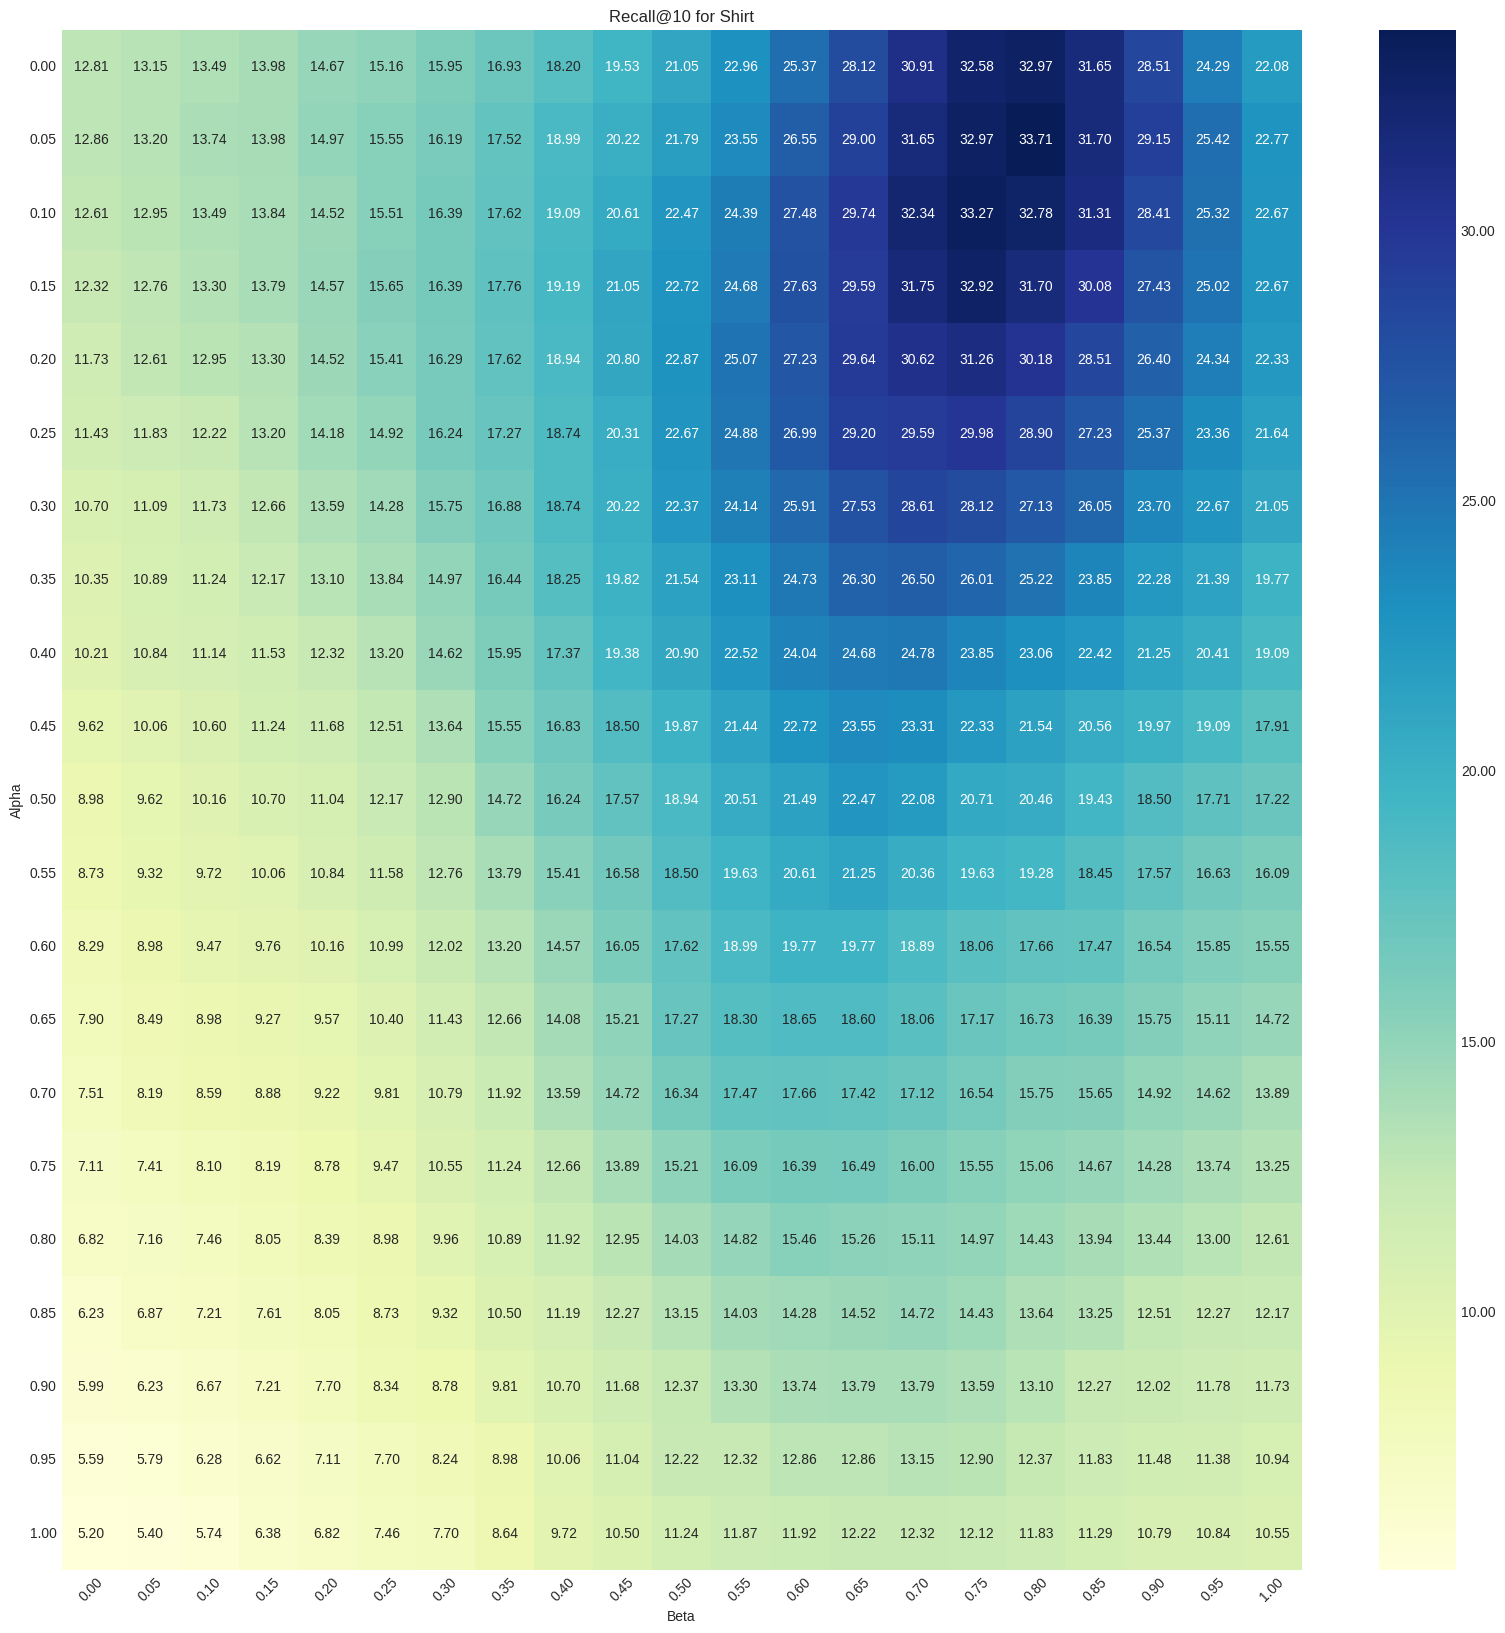

In [34]:
prepare_and_plot_recall_pivot(shirt_recall_at10, "Recall@10 for Shirt")

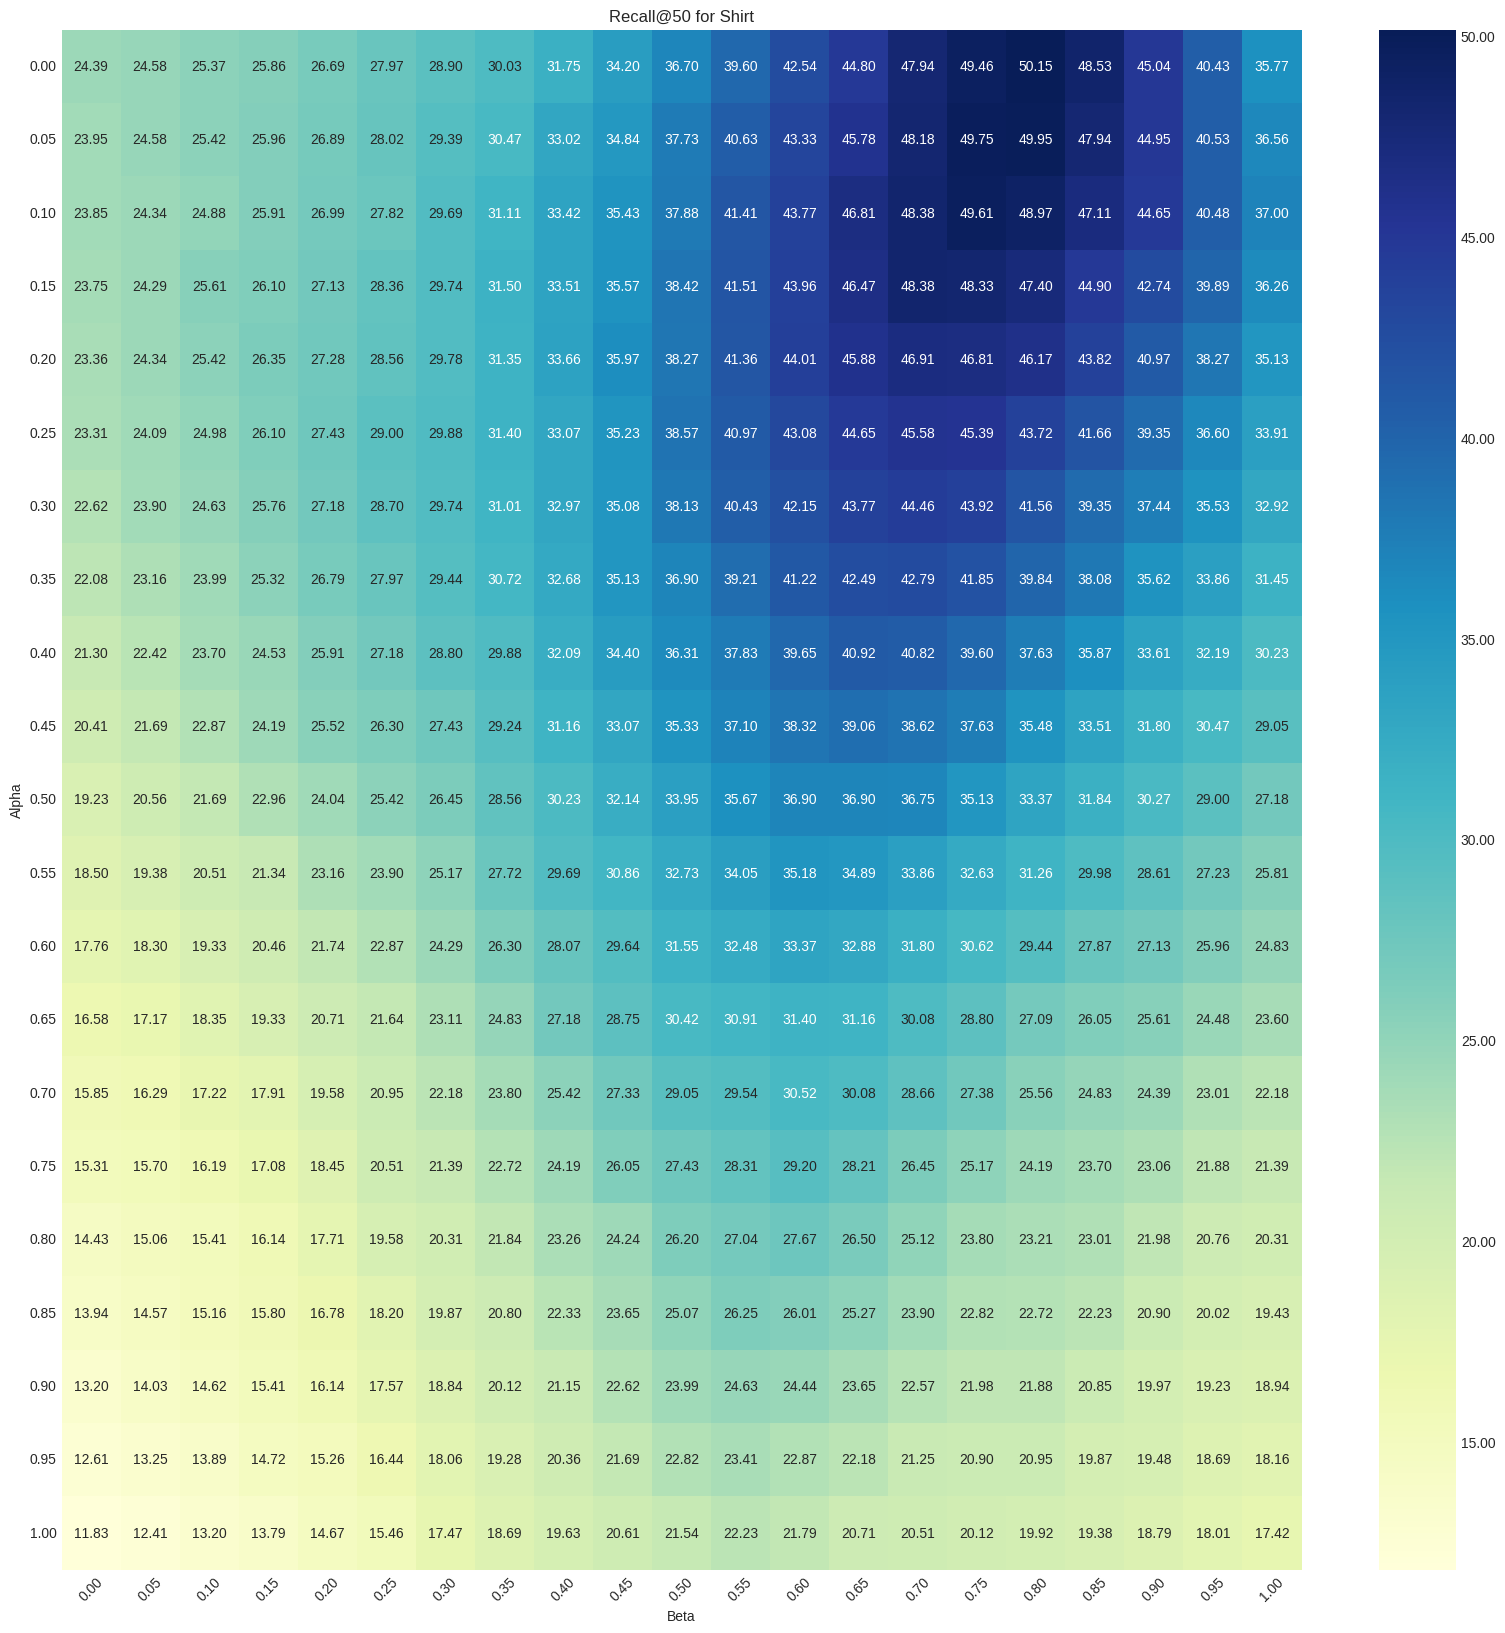

In [35]:
prepare_and_plot_recall_pivot(shirt_recall_at50, "Recall@50 for Shirt")

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the recall at 10 and 50 for Dress</div>

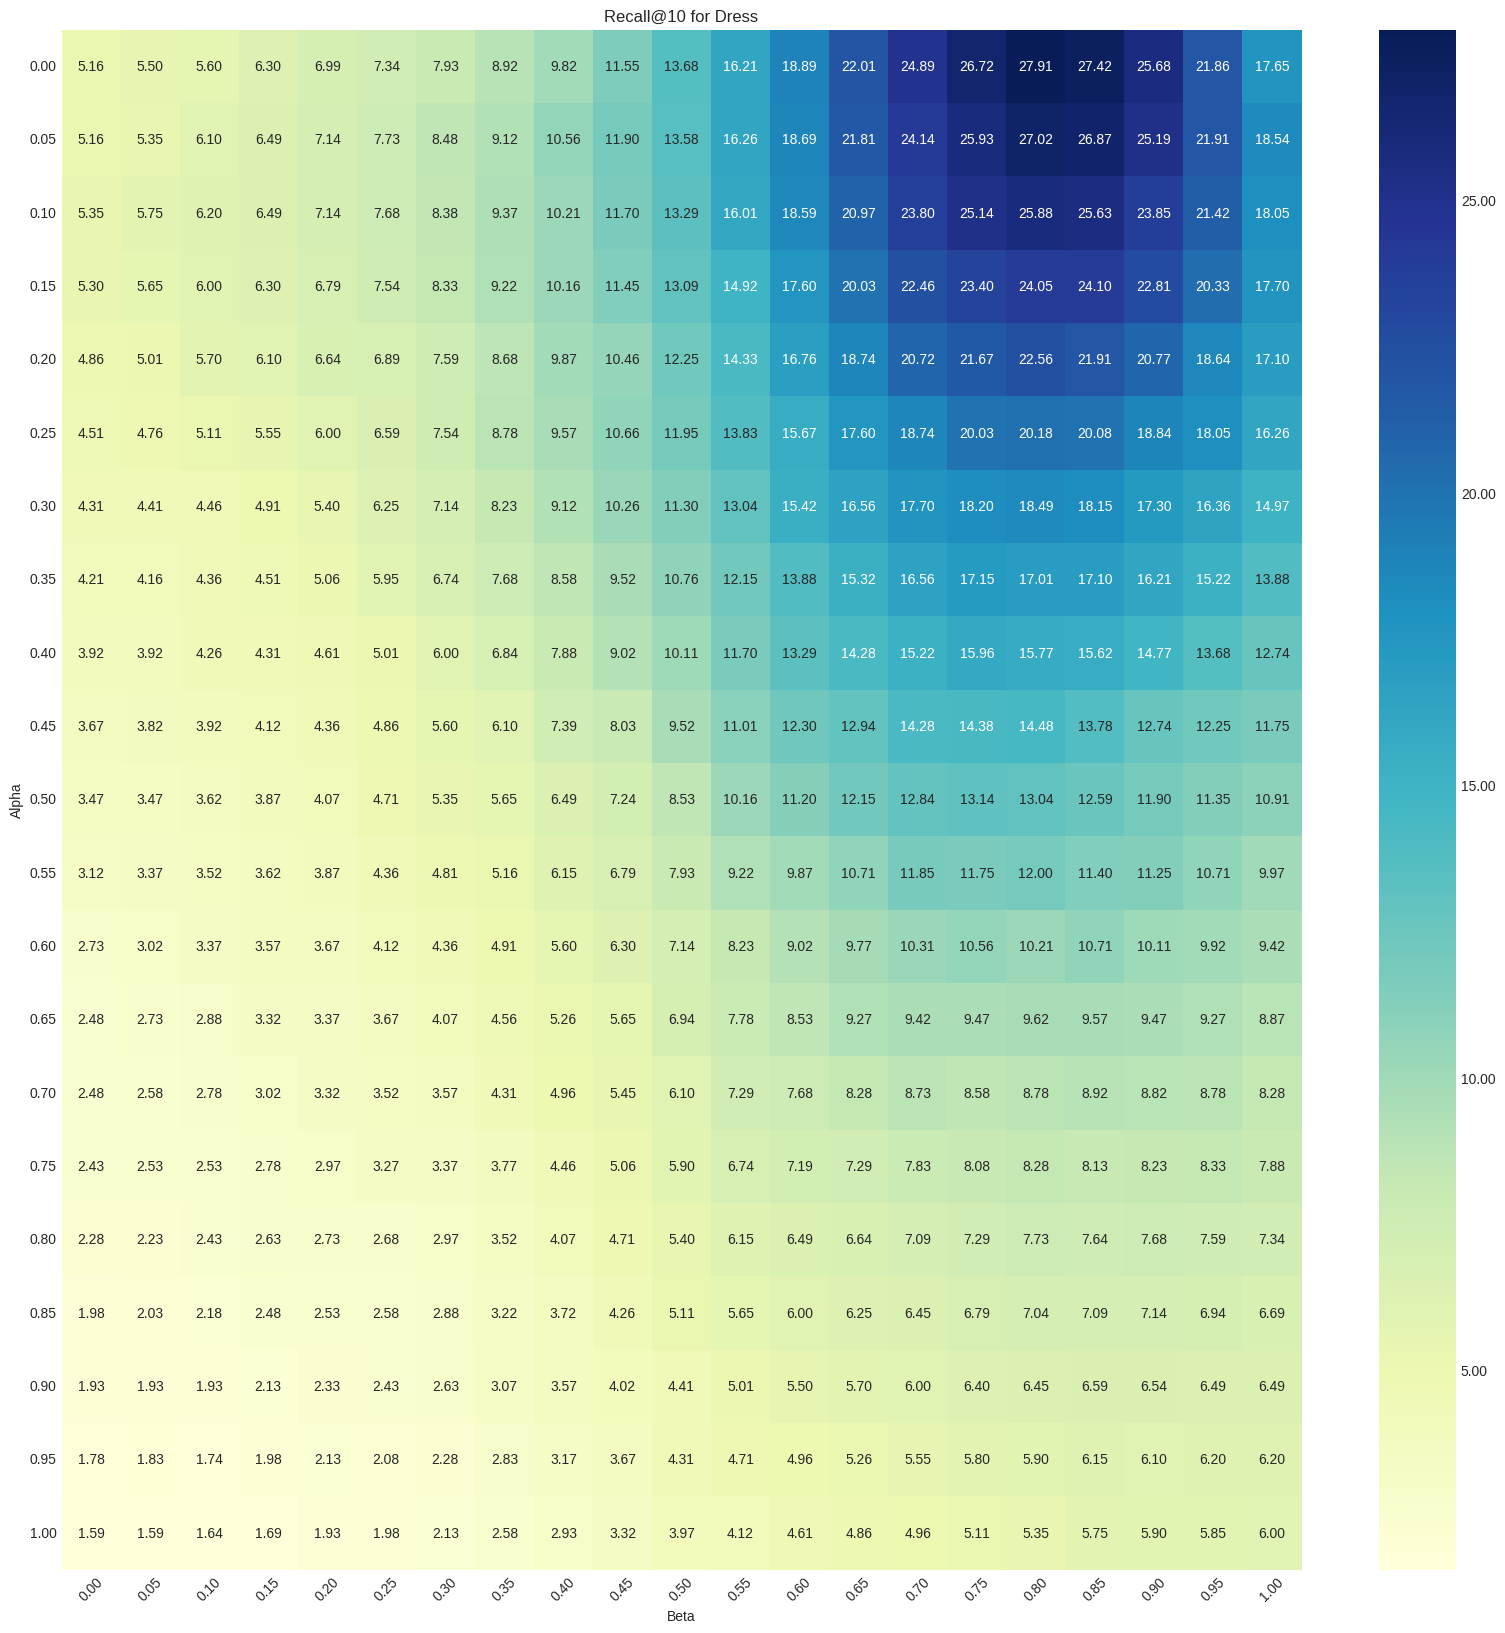

In [36]:
prepare_and_plot_recall_pivot(dress_recall_at10, "Recall@10 for Dress")

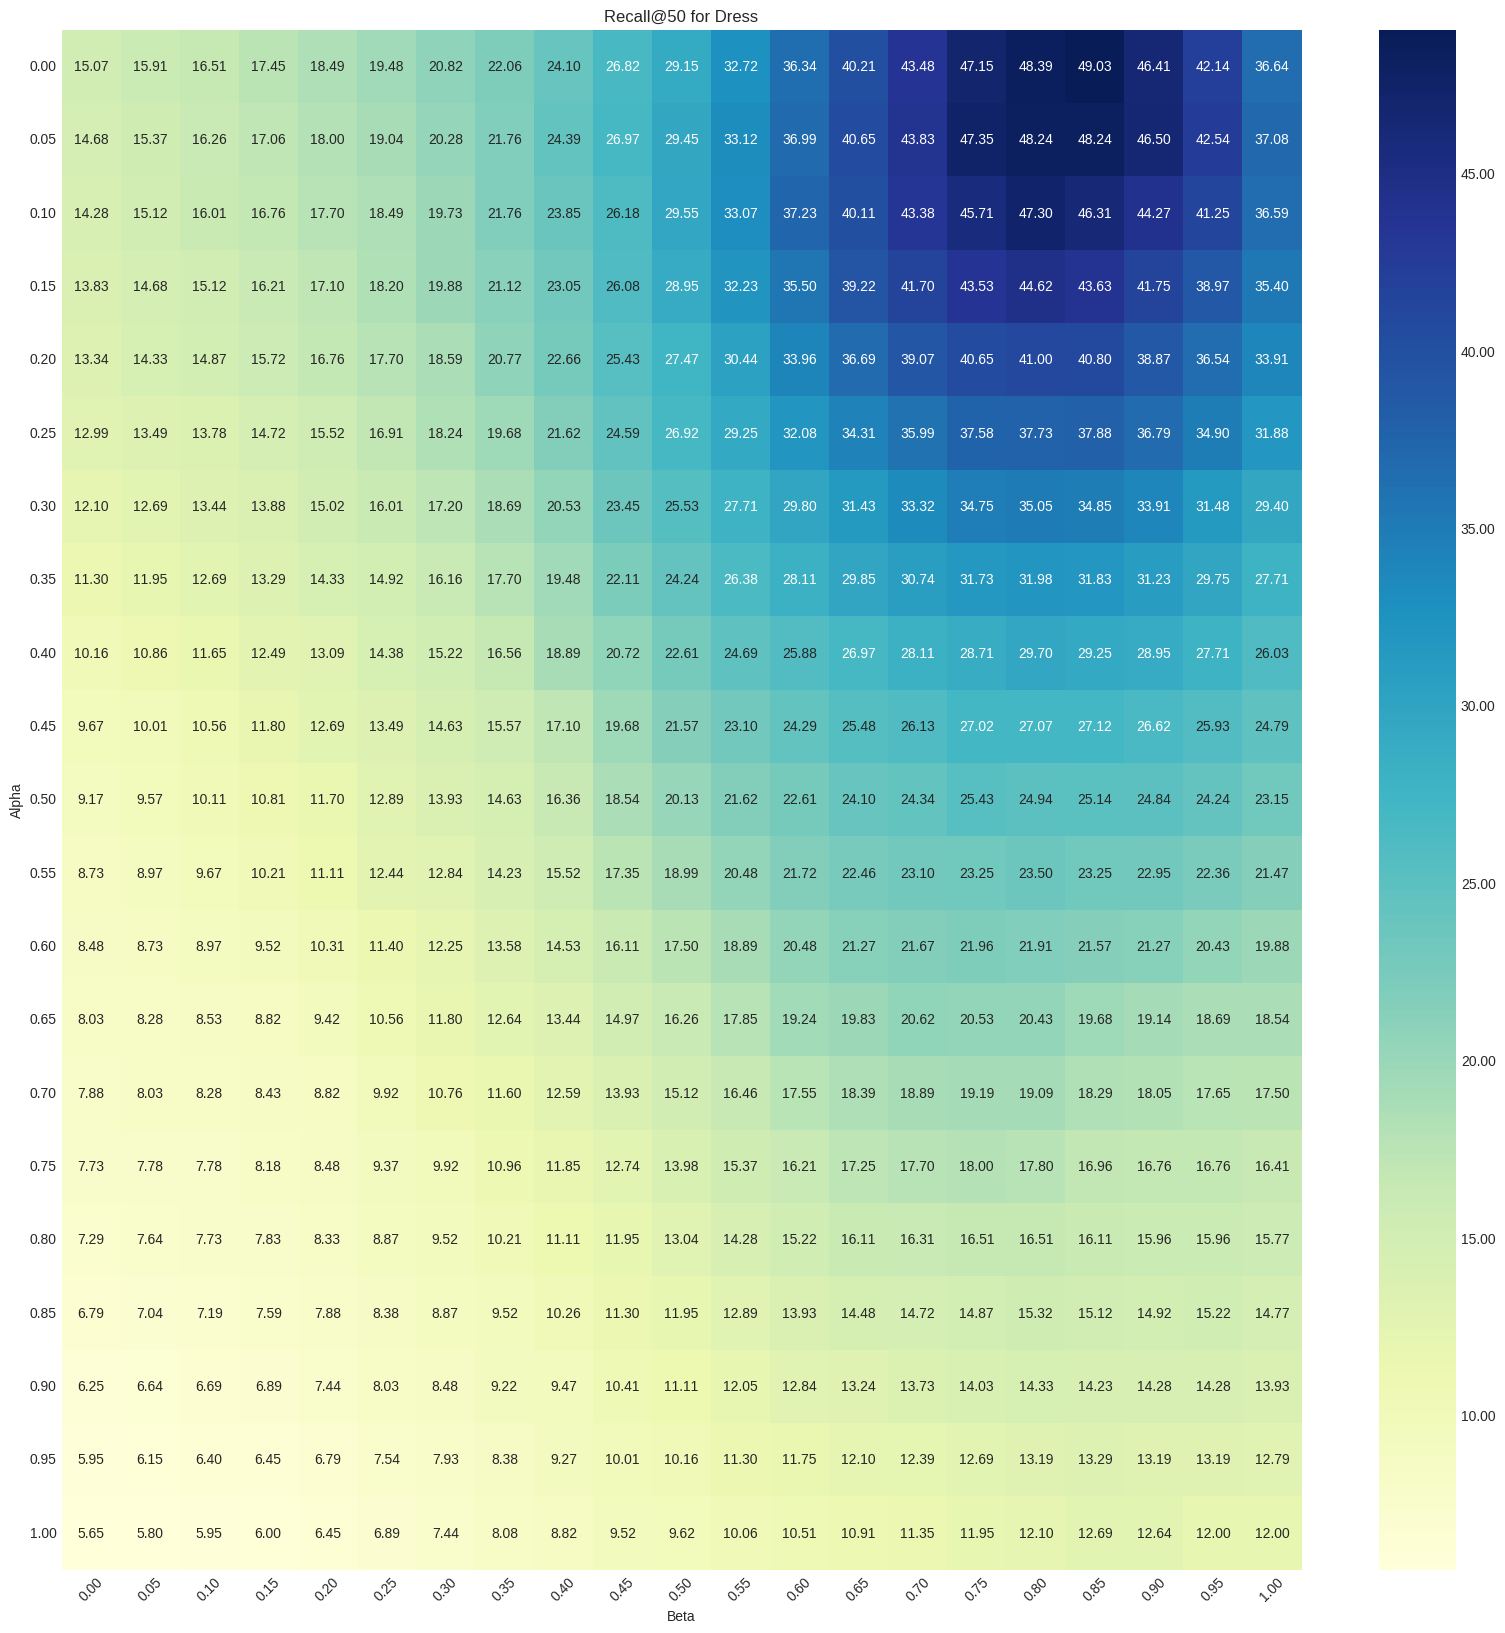

In [37]:
prepare_and_plot_recall_pivot(dress_recall_at50, "Recall@50 for Dress")

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the recall at 10 and 50 for TopTee</div>

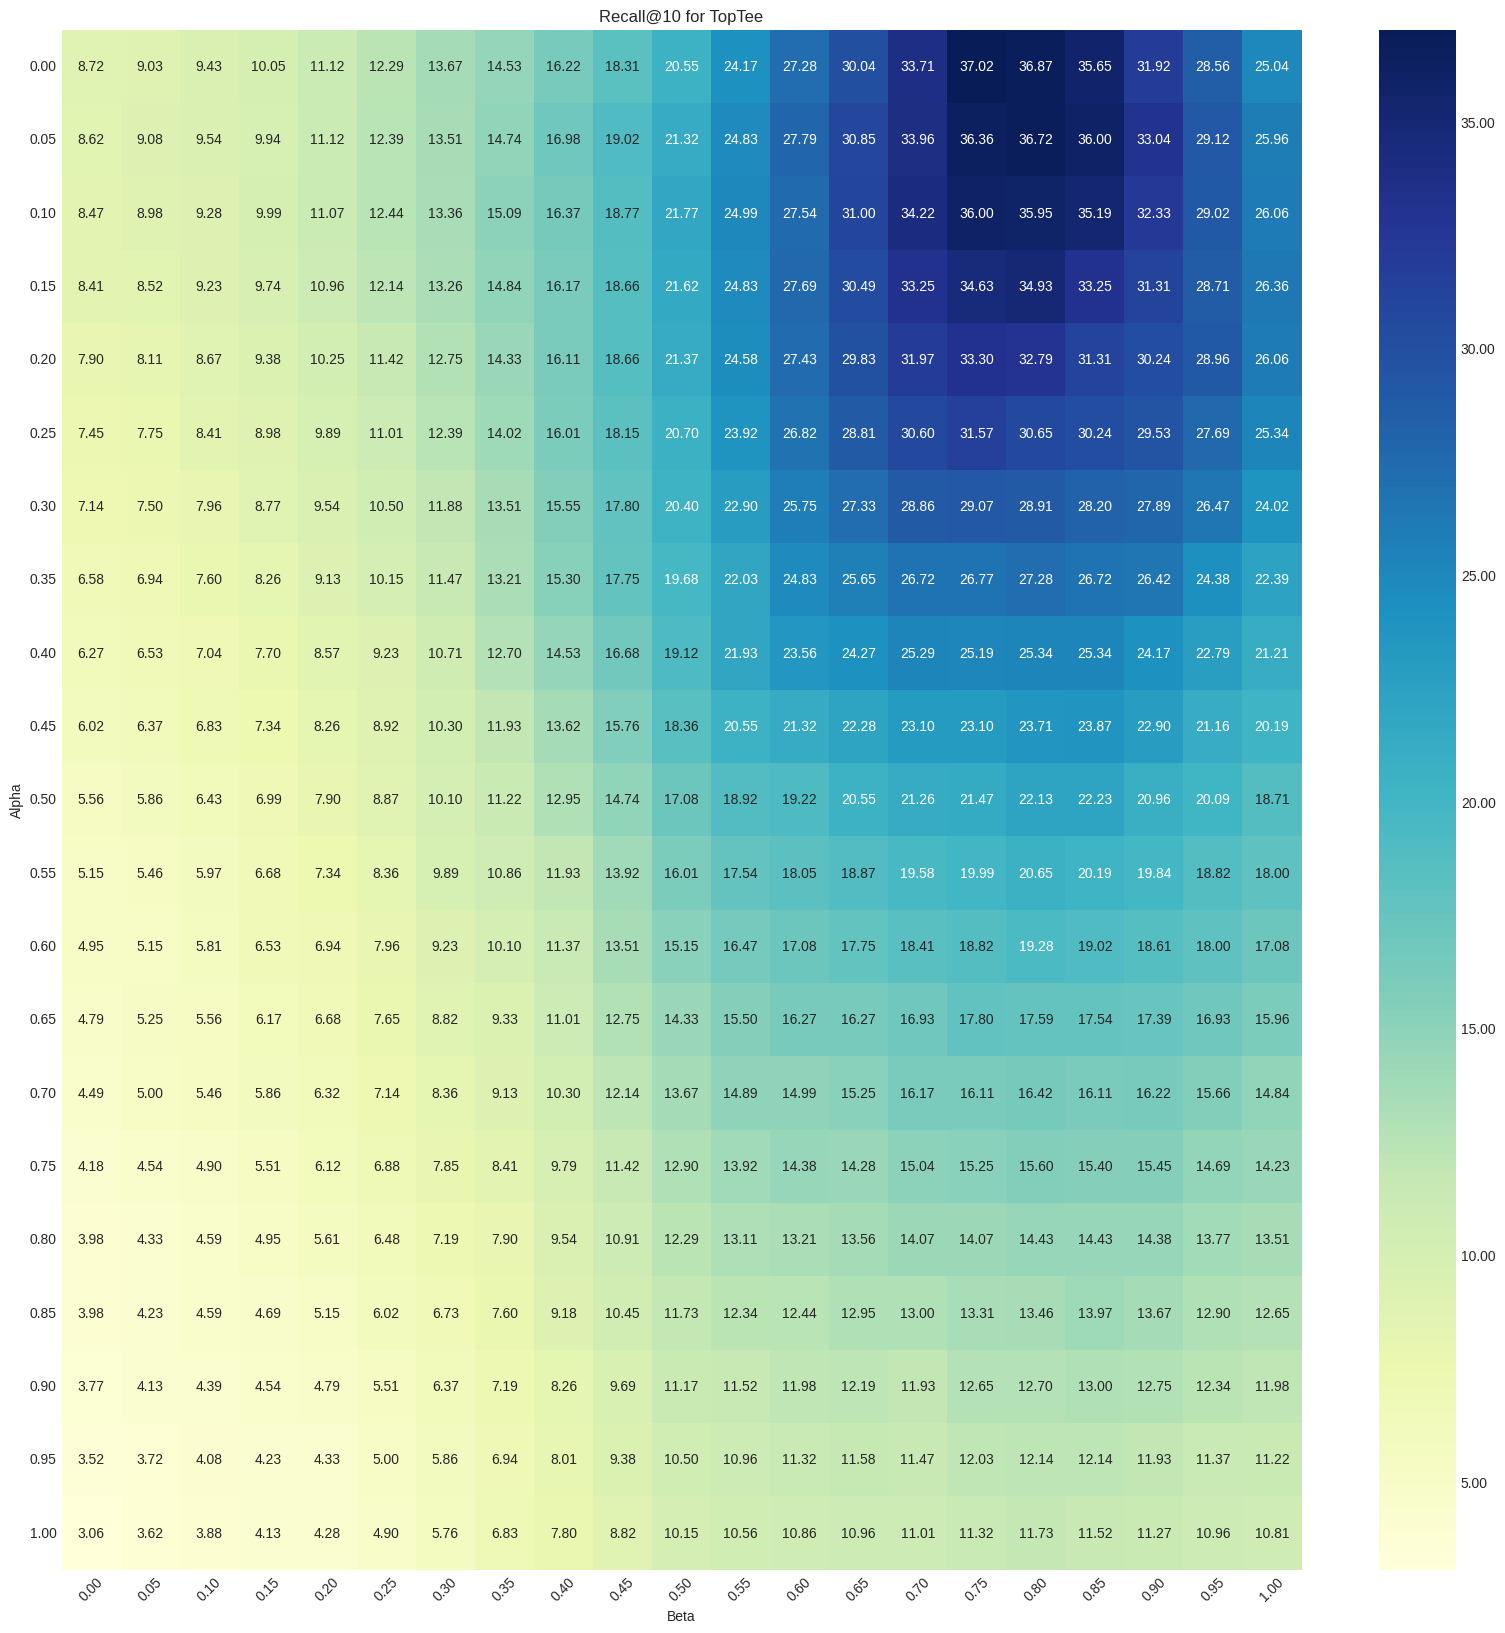

In [38]:
prepare_and_plot_recall_pivot(toptee_recall_at10, "Recall@10 for TopTee")

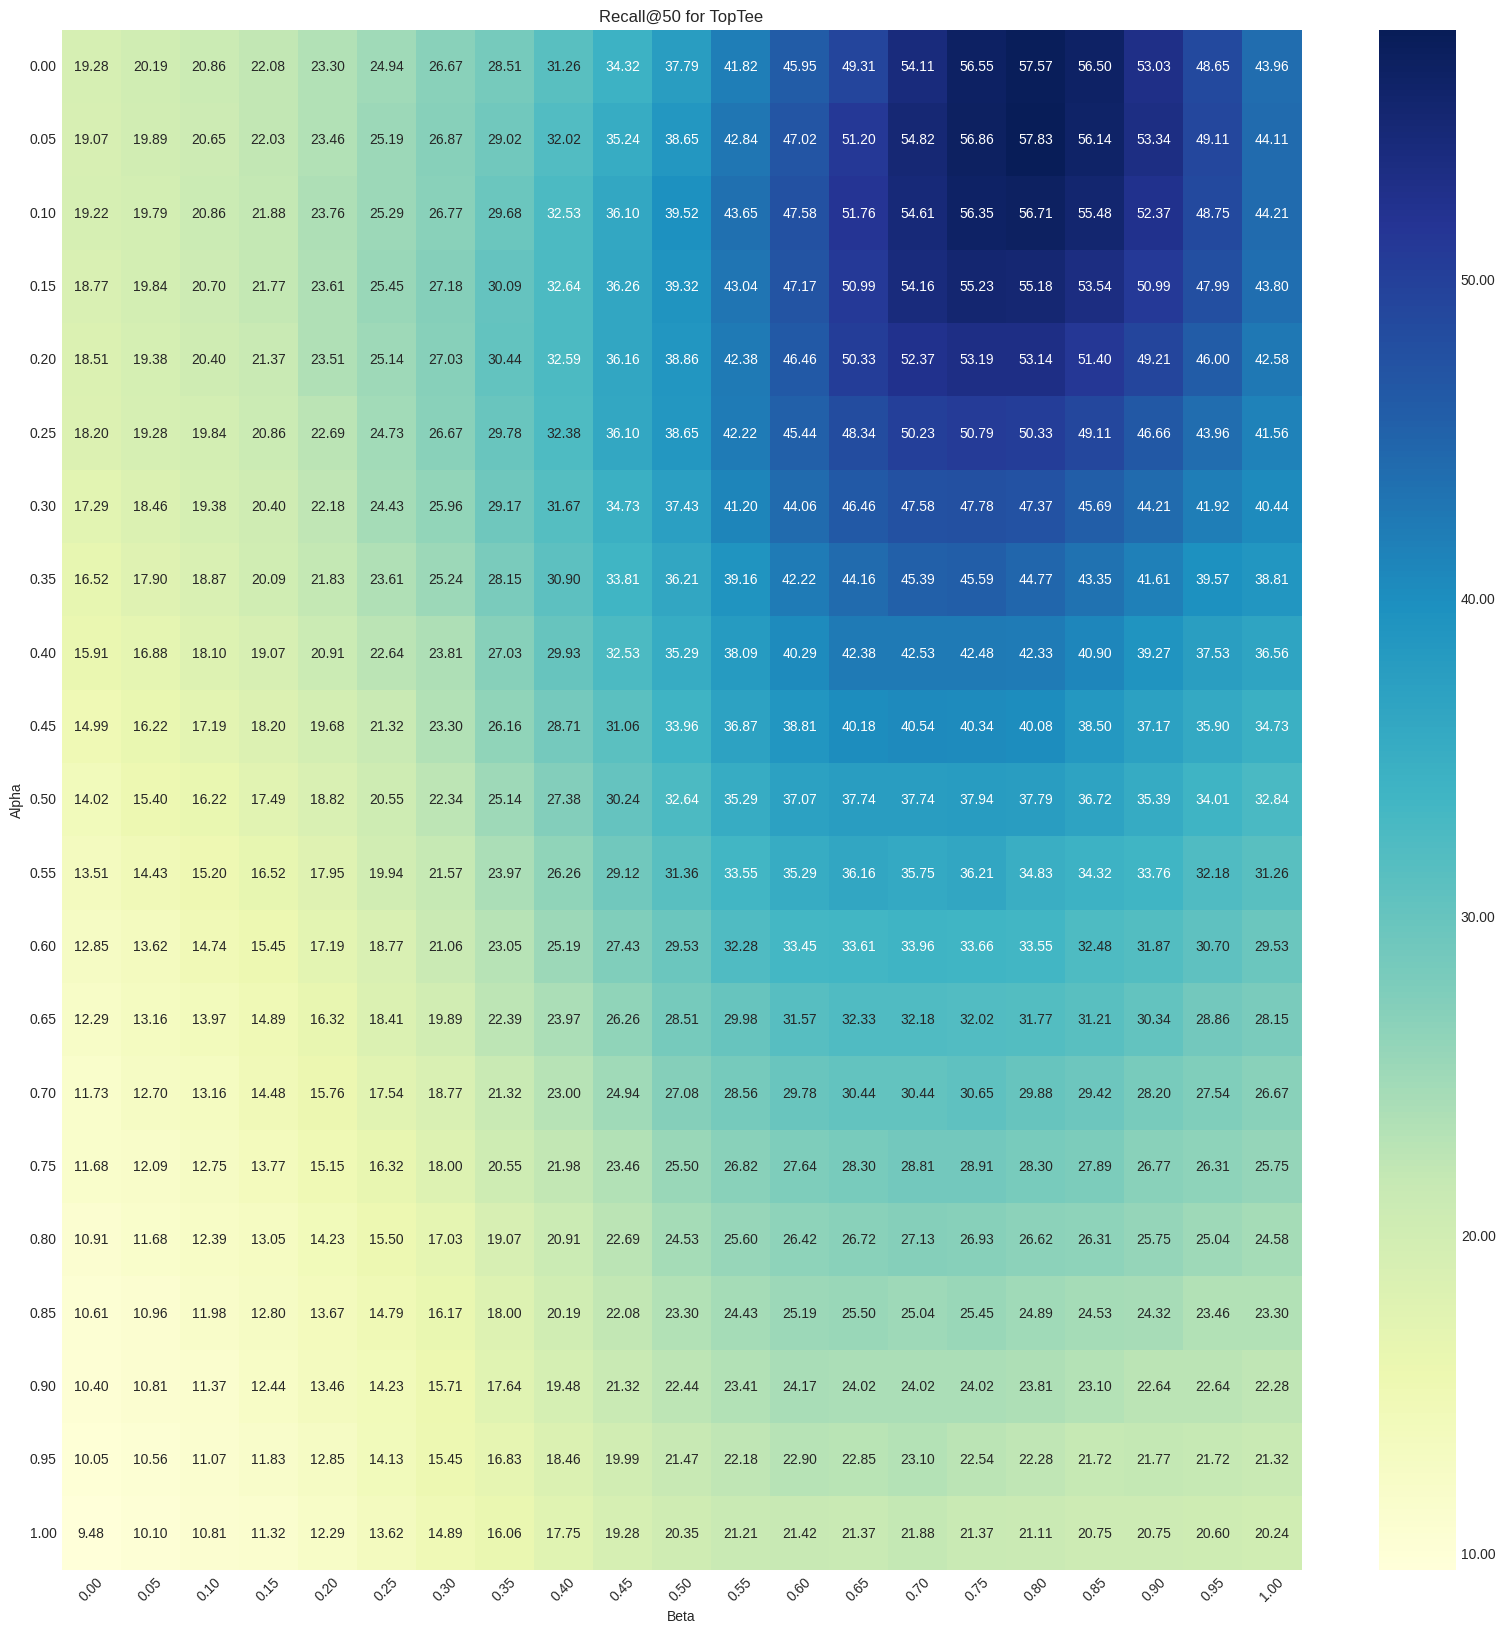

In [39]:
prepare_and_plot_recall_pivot(toptee_recall_at50, "Recall@50 for TopTee")

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the average recall at 10 and 50 for all categories</div>

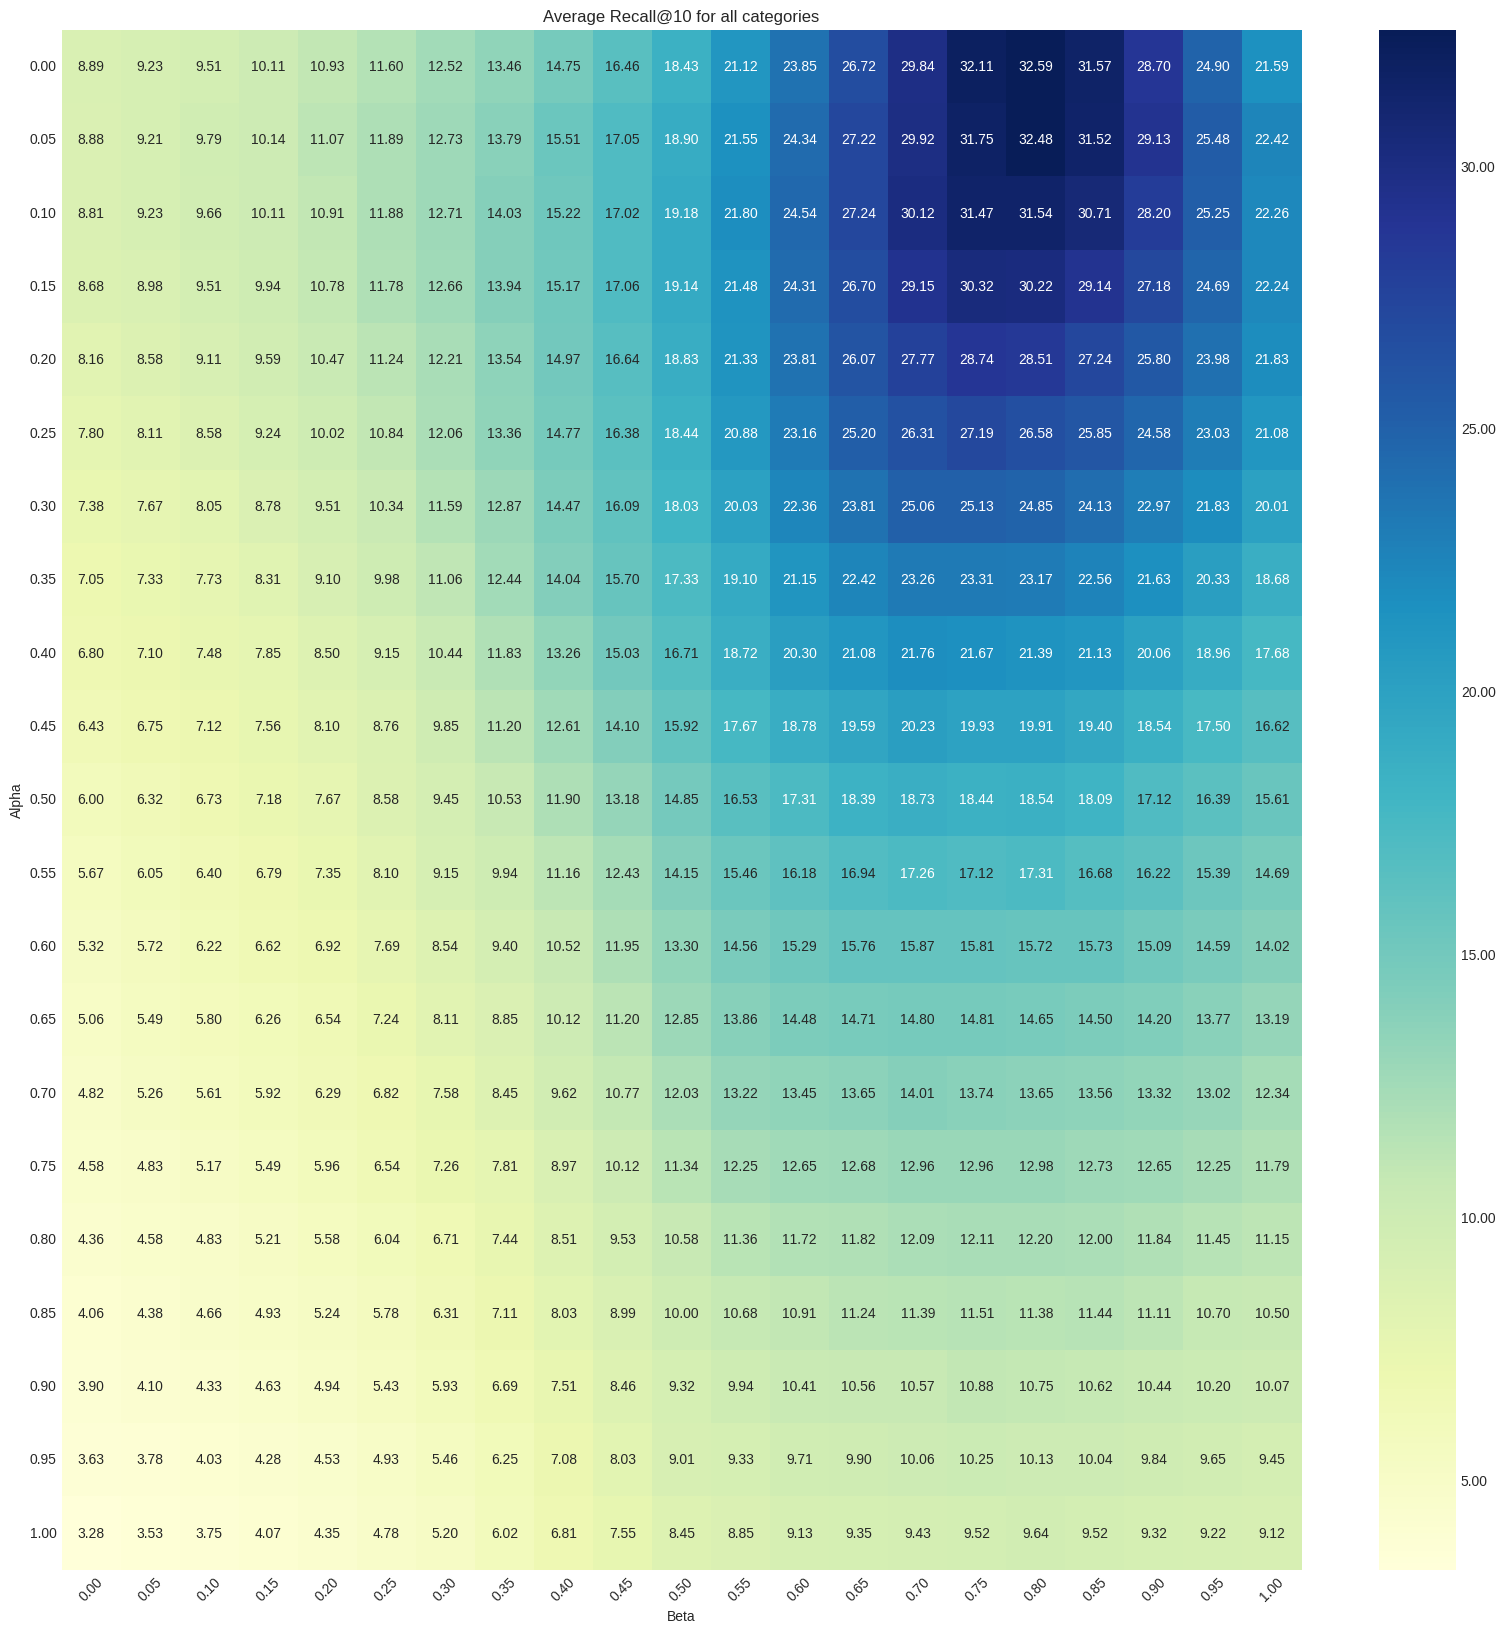

In [40]:
prepare_and_plot_recall_pivot(average_recall_at10, "Average Recall@10 for all categories")

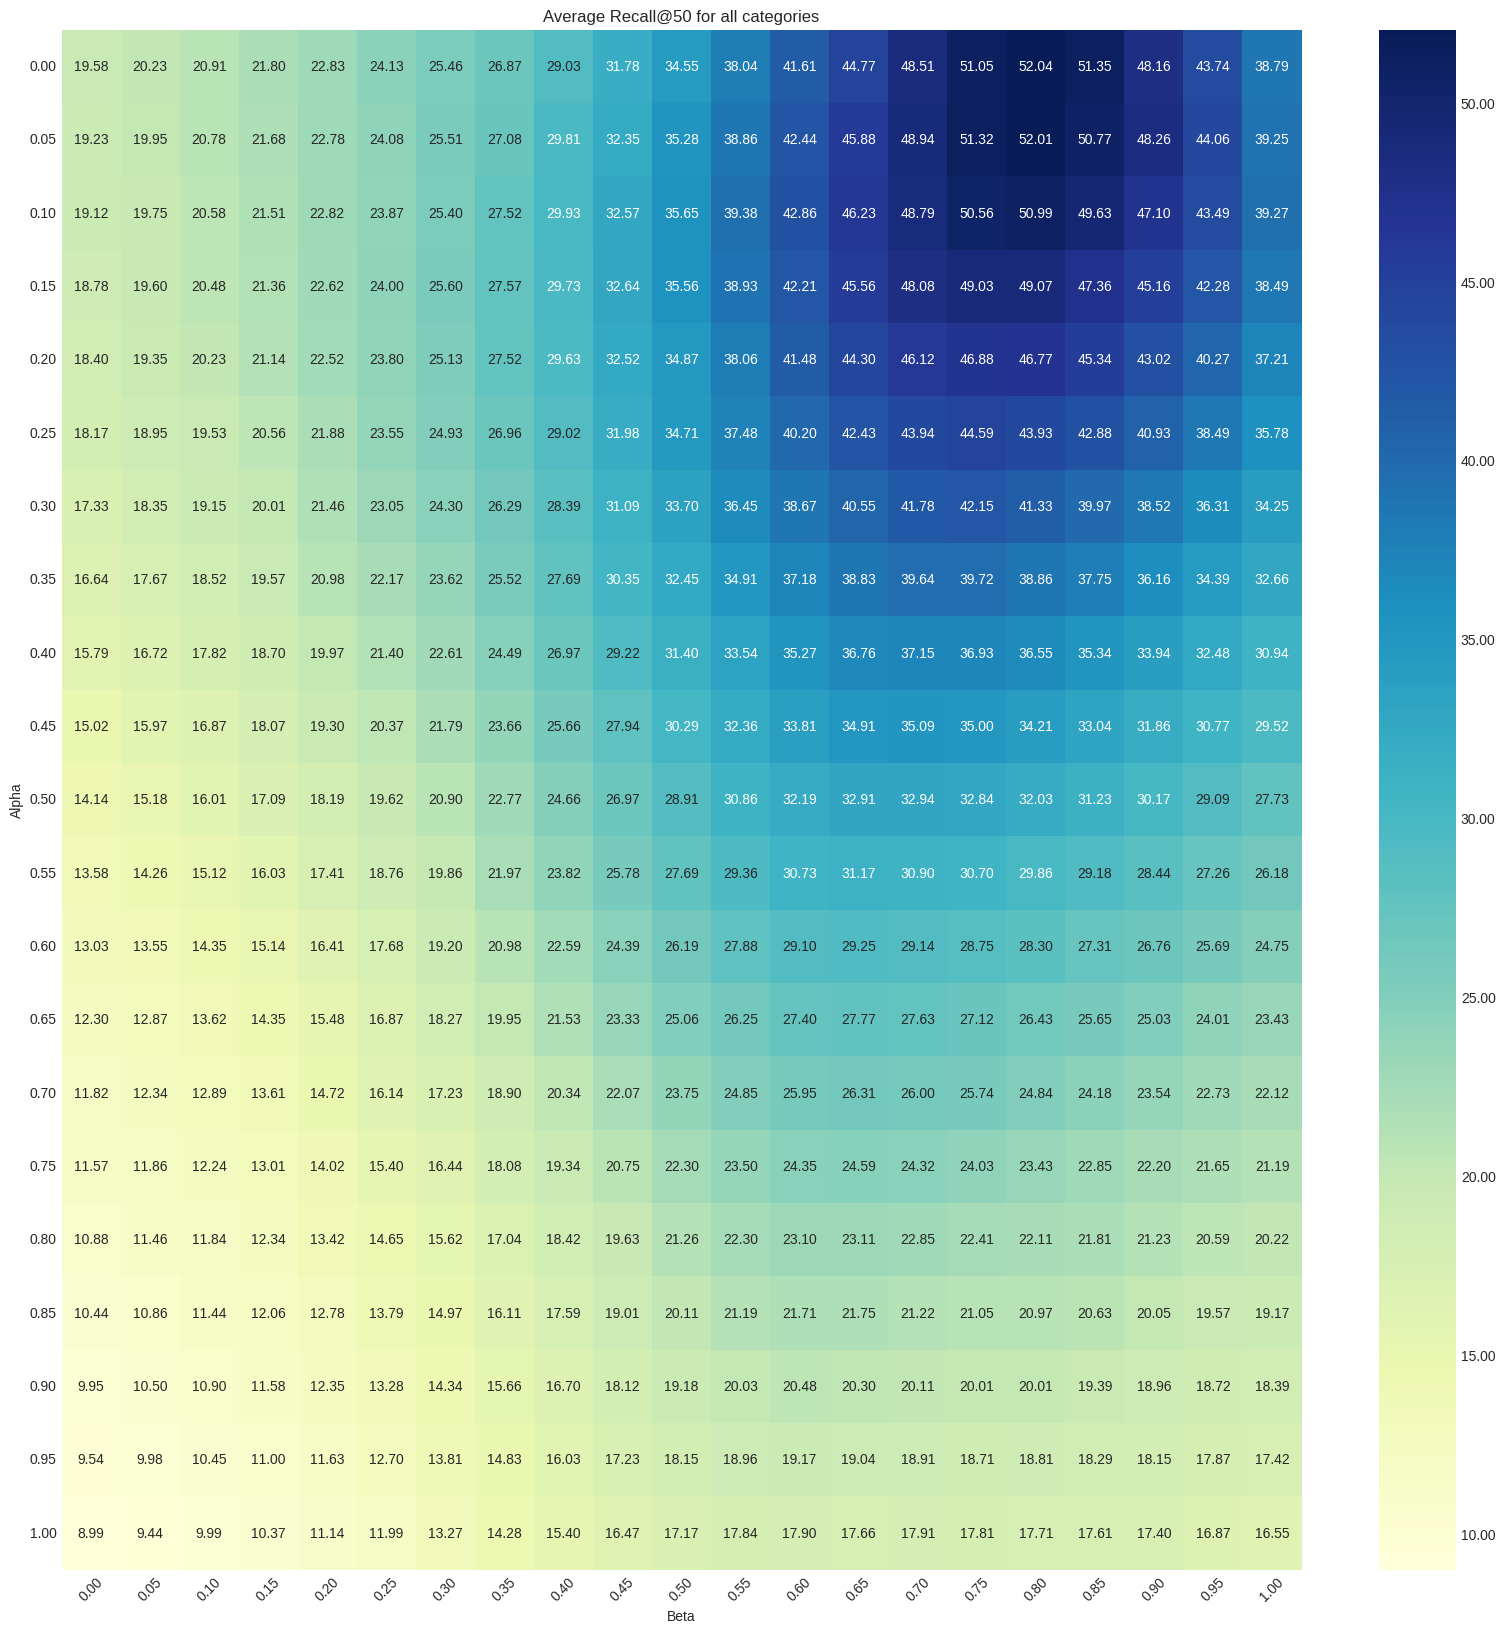

In [41]:
prepare_and_plot_recall_pivot(average_recall_at50, "Average Recall@50 for all categories")

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 5: View some sample of the result</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Define the function to compute the results</div>

In [42]:
def compute_results(
    dress_type: str,
    combining_function: callable,
    clip_text_encoder: torch.nn.Module,
    clip_img_encoder: torch.nn.Module,
    clip_tokenizer: callable,
    text_captions: List[dict],
    preprocess: callable,
    alpha: float = 0.65
) -> Tuple[torch.tensor, List[str], List[str]]:
    """
    View sample results on FashionIQ dataset combining text and image distances.
    
    :param dress_type: FashionIQ category on which perform the retrieval
    :param combining_function:function which takes as input (image_features, text_features) and outputs the combined features
    :param clip_text_encoder: BLIP text model
    :param clip_img_encoder: BLIP image model
    :param clip_tokenizer: BLIP tokenizer
    :param text_captions: text captions for the FashionIQ dataset
    :param preprocess: preprocess pipeline
    :param alpha: alpha value for combining text and image distances
    
    :return: [(image_path, text_caption, candidate_image_paths)]
    """
    global cache
    cache_key = f"{dress_type}_cache"
    clip_text_encoder = clip_text_encoder.float().eval()
    clip_img_encoder = clip_img_encoder.float().eval()

    if cache_key not in cache:
        # Define the validation datasets and extract the index features
        classic_val_dataset = FashionIQDataset('val', [dress_type], 'classic', preprocess)
    
        multiple_index_features, multiple_index_names = [], []
    
        for i in range(3):
            index_features, index_names, _ = extract_index_features_with_text_captions_clip(
                classic_val_dataset,
                clip_text_encoder,
                clip_tokenizer,
                text_captions,
                i + 1
            )
            multiple_index_features.append(index_features)
            multiple_index_names.append(index_names)

        image_index_features, image_index_names = extract_index_features_clip(
            classic_val_dataset,
            clip_img_encoder
        )
    else:
        multiple_index_features = cache[cache_key]["multiple_index_features"]
        multiple_index_names = cache[cache_key]["multiple_index_names"]
        image_index_features = cache[cache_key]["image_index_features"]
        image_index_names = cache[cache_key]["image_index_names"]

    relative_val_dataset = FashionIQDataset('val', [dress_type], 'relative', preprocess)

    all_text_distances = []

    # Compute distances for individual text features
    for text_features, text_names in zip(multiple_index_features, multiple_index_names):
        # Generate text predictions and normalize features
        predicted_text_features, target_names = generate_fiq_val_predictions(
            clip_text_encoder, 
            clip_tokenizer,
            relative_val_dataset,
            combining_function, 
            text_names,
            text_features
        )
        # Normalize features
        text_features = F.normalize(text_features, dim=-1)
        predicted_text_features = F.normalize(predicted_text_features, dim=-1)

        # Compute cosine similarity and convert to distance
        cosine_similarities = torch.mm(predicted_text_features, text_features.T)
        distances = 1 - cosine_similarities
        all_text_distances.append(distances)

    predicted_image_features, target_names = generate_fiq_val_predictions(
        clip_text_encoder,
        clip_tokenizer,
        relative_val_dataset,
        combining_function,
        image_index_names,
        image_index_features
    )

    # Normalize and compute distances
    image_index_features = F.normalize(image_index_features, dim=-1).float()
    image_distances = 1 - predicted_image_features @ image_index_features.T

    # Merge text distances
    merged_text_distances = torch.mean(torch.stack(all_text_distances), dim=0)

    merged_distances = alpha * merged_text_distances + (1 - alpha) * image_distances

    sorted_indices = torch.argsort(merged_distances, dim=-1).cpu()
    sorted_index_names = np.array(image_index_names if image_index_names else multiple_index_names[0])[sorted_indices]
    labels = torch.tensor(
        sorted_index_names == np.repeat(
            np.array(target_names),
            len(image_index_names if image_index_names else multiple_index_names[0])
        ).reshape(len(target_names), -1)
    )
    assert torch.equal(torch.sum(labels, dim=-1).int(), torch.ones(len(target_names)).int())
    recall_at10 = (torch.sum(labels[:, :10]) / len(labels)).item() * 100
    recall_at50 = (torch.sum(labels[:, :50]) / len(labels)).item() * 100

    print(f"Recall at 10: {recall_at10}")
    print(f"Recall at 50: {recall_at50}")

    return sorted_indices, image_index_names, target_names

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Dress category</div>

In [43]:
sorted_indices_dress, image_index_names_dress, target_names_dress = compute_results(
    'dress',
    get_combing_function_with_beta(0.8),
    clip_text_encoder,
    clip_img_encoder,
    clip_tokenizer,
    text_captions,
    preprocess,
    alpha=0
)

FashionIQ val - ['dress'] dataset in relative mode initialized


100%|██████████| 64/64 [00:02<00:00, 24.60it/s]


Recall at 10: 27.912741899490356

Recall at 50: 48.38869571685791

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Shirt category</div>

In [44]:
sorted_indices_shirt, image_index_names_shirt, target_names_shirt = compute_results(
    'shirt',
    get_combing_function_with_beta(0.8),
    clip_text_encoder,
    clip_img_encoder,
    clip_tokenizer,
    text_captions,
    preprocess,
    alpha=0
)

FashionIQ val - ['shirt'] dataset in relative mode initialized


100%|██████████| 64/64 [00:02<00:00, 26.47it/s]


Recall at 10: 32.973504066467285

Recall at 50: 50.14720559120178

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the TopTee category</div>

In [45]:
sorted_indices_toptee, image_index_names_toptee, target_names_toptee = compute_results(
    'toptee',
    get_combing_function_with_beta(0.8),
    clip_text_encoder,
    clip_img_encoder,
    clip_tokenizer,
    text_captions,
    preprocess,
    alpha=0
)

FashionIQ val - ['toptee'] dataset in relative mode initialized


100%|██████████| 62/62 [00:02<00:00, 27.55it/s]


Recall at 10: 36.86894476413727

Recall at 50: 57.57266879081726

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Prepare the ground truth data</div>

In [49]:
def prepare_ground_truths(json_data):
    """
    Prepare ground truth data from the JSON structure.
    
    :param json_data: JSON data containing target and candidate matches with captions
    :return: Dictionary mapping targets to lists of tuples (candidates and captions)
    """
    ground_truths = {}
    for entry in json_data:
        target = entry['target']
        candidate = entry['candidate']
        captions = entry['captions']
        if target not in ground_truths:
            ground_truths[target] = []
        ground_truths[target].append((candidate, captions))  # Store as a tuple
    return ground_truths

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the retrieval results for a query</div>

In [50]:
def plot_retrieval_results_of_i(sorted_indices, image_index_names, target_names, ground_truths, top_k=5, i=0):
    """
    Plot retrieval results for a specific query showing the query and its top retrieved images, highlighting ground truths
    and displaying associated captions to the left of the query image.

    :param sorted_indices: 2D tensor or array with sorted indices of retrieved images per query.
    :param image_index_names: List of image paths corresponding to indices in sorted_indices.
    :param target_names: List of names or descriptions for each query.
    :param ground_truths: Dictionary mapping target names to lists of tuples (candidates and captions).
    :param top_k: Number of top retrieved results to display per query.
    :param i: Index of the query to display.
    """
    query_index = i
    retrival_result_images = [image_index_names[j] for j in sorted_indices[query_index]][:top_k]
    ground_truth_target = target_names[query_index]
    query_img_path, query_captions = ground_truths.get(ground_truth_target, [('', '')])[0]

    fig = plt.figure(figsize=(30, 5))
    gs = GridSpec(1, top_k + 2, figure=fig)
    query_img = Image.open(f'../fashionIQ_dataset/images/{query_img_path}.png')

    # Subplot for the caption text to the left of the query image
    ax_text = fig.add_subplot(gs[0, 0])
    query_name = query_img_path
    query_captions = '\n'.join(sentences for sentences in query_captions)
    ax_text.text(0.5, 0.5, query_captions, va='center', ha='center')
    ax_text.axis('off')

    # Subplot for the query image
    ax_image = fig.add_subplot(gs[0, 1])
    ax_image.imshow(query_img)
    ax_image.set_title(f"Query: {query_name}", color='blue')
    ax_image.axis('off')

    for j, img_path in enumerate(retrival_result_images):
        img = Image.open(f'../fashionIQ_dataset/images/{img_path}.png')

        ax_result = fig.add_subplot(gs[0, j + 2])
        ax_result.imshow(img)

        # Check if this image is a ground truth and retrieve its captions
        if img_path == ground_truth_target:
            ax_result.set_title(f"{img_path}", color='green')
        else:
            ax_result.set_title(img_path)

        ax_result.axis('off')

    plt.tight_layout()
    plt.show()

In [51]:
ground_truth_dress = prepare_ground_truths(json.load(open('../fashionIQ_dataset/captions/cap.dress.val.json')))
ground_truth_shirt = prepare_ground_truths(json.load(open('../fashionIQ_dataset/captions/cap.shirt.val.json')))
ground_truth_toptee = prepare_ground_truths(json.load(open('../fashionIQ_dataset/captions/cap.toptee.val.json')))

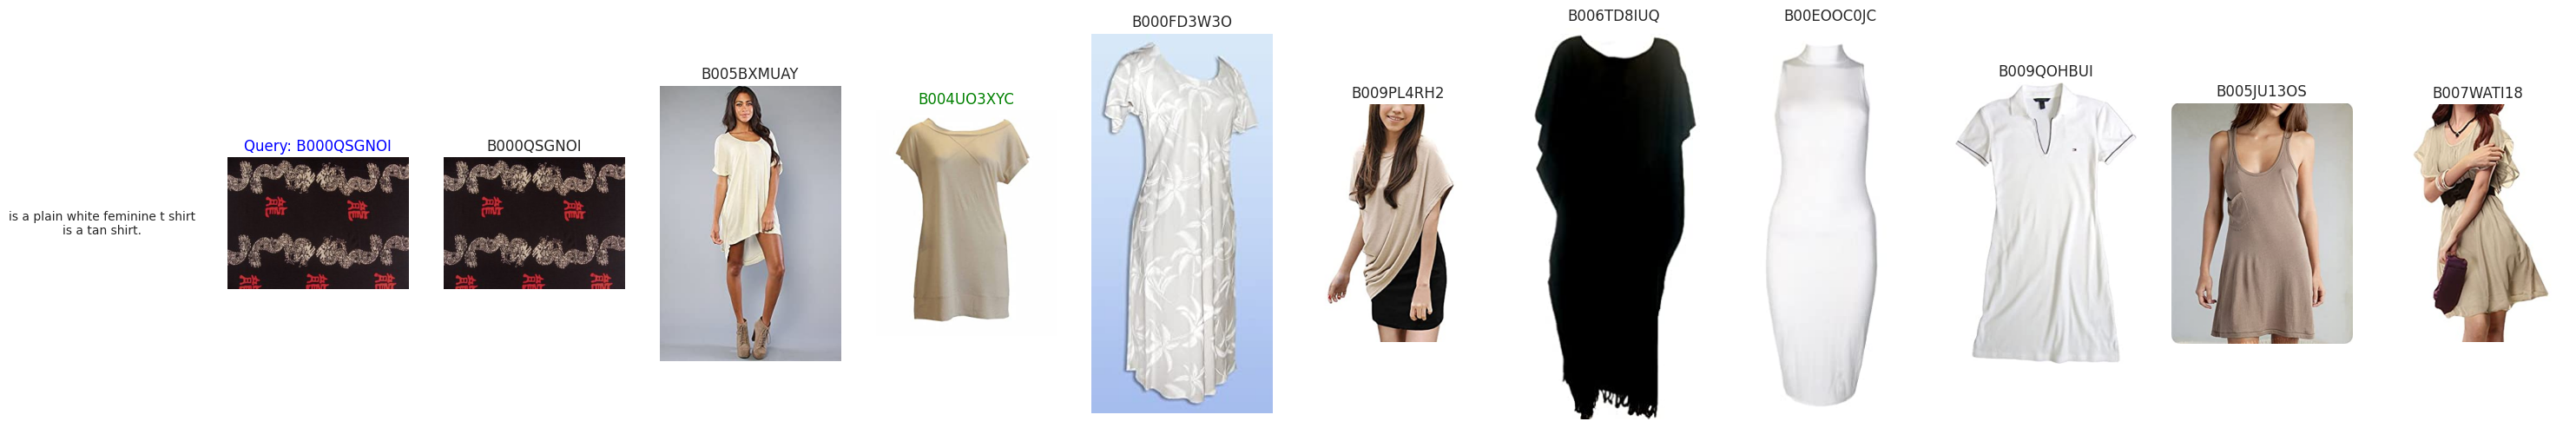

In [52]:
plot_retrieval_results_of_i(sorted_indices_dress, image_index_names_dress, target_names_dress, ground_truth_dress, top_k=10, i=3)

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 6: Compare with alpha=0, and without weighted merge beta</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Dress category with alpha=0 and without weighted merge beta</div>

In [53]:
sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin = compute_results(
    'dress',
    combining_function_original,
    clip_text_encoder,
    clip_img_encoder,
    clip_tokenizer,
    text_captions,
    preprocess,
    alpha=0
)

FashionIQ val - ['dress'] dataset in relative mode initialized


100%|██████████| 64/64 [00:02<00:00, 29.13it/s]


Recall at 10: 13.683688640594482

Recall at 50: 29.15220558643341

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Shirt category with alpha=0 and without weighted merge beta</div>

In [54]:
sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin = compute_results(
    'shirt',
    combining_function_original,
    clip_text_encoder,
    clip_img_encoder,
    clip_tokenizer,
    text_captions,
    preprocess,
    alpha=0
)

FashionIQ val - ['shirt'] dataset in relative mode initialized


100%|██████████| 64/64 [00:02<00:00, 23.13it/s]


Recall at 10: 21.050049364566803

Recall at 50: 36.70265078544617

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the TopTee category with alpha=0 and without weighted merge beta</div>

In [55]:
sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin = compute_results(
    'toptee',
    combining_function_original,
    clip_text_encoder,
    clip_img_encoder,
    clip_tokenizer,
    text_captions,
    preprocess,
    alpha=0
)

FashionIQ val - ['toptee'] dataset in relative mode initialized


100%|██████████| 62/62 [00:02<00:00, 26.13it/s]


Recall at 10: 20.550739765167236

Recall at 50: 37.78684437274933

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compare the results</div>

In [56]:
def found_better_than_original(
        sorted_indices_origin, image_index_names_origin, target_names_origin,
        sorted_indices, image_index_names, target_names, top_k=10
) -> List[int]:
    """
    Return indices of queries where the new retrieval results are better than the original results based on the rank
    of the ground truth in the top_k results.

    Args:
        sorted_indices_origin (np.ndarray): 2D array of sorted indices by relevance per query for the original method.
        image_index_names_origin (List[str]): List of image names corresponding to indices in sorted_indices_origin.
        target_names_origin (List[str]): List of names or descriptions for each query for the original method.
        sorted_indices (np.ndarray): 2D array of sorted indices by relevance per query for the new method.
        image_index_names (List[str]): List of image names corresponding to indices in sorted_indices.
        target_names (List[str]): List of target names each query is supposed to retrieve.
        top_k (int): Number of top retrieved results to consider per query.

    Returns:
        List[int]: List of indices where the new method outperforms the original method in terms of the rank of the
        ground truth target.
    """
    better_indices = []
    total_queries = len(target_names)  # Assuming the same number of queries for both sets

    for index in range(total_queries):
        # Find the index of the ground truth in the top_k results of the original method
        new_rank = [image_index_names[i] for i in sorted_indices[index]].index(target_names[index])
        origin_rank = [image_index_names_origin[i] for i in sorted_indices_origin[index]].index(target_names_origin[index])

        if new_rank <= top_k < origin_rank:
            better_indices.append(index)

    return better_indices

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compare the results for the Dress category</div>

In [57]:
become_better = found_better_than_original(
    sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin,
    sorted_indices_dress, image_index_names_dress, target_names_dress,
    top_k=10
)

len(become_better), become_better[:10]

(344, [1, 3, 12, 15, 16, 19, 27, 38, 40, 43])

In [58]:
become_worse = found_better_than_original(
    sorted_indices_dress, image_index_names_dress, target_names_dress,
    sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin,
    top_k=10
)

len(become_worse), become_worse[:10]

(53, [41, 61, 62, 87, 120, 134, 215, 218, 262, 277])

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compare the results for the Shirt category</div>

In [59]:
become_better = found_better_than_original(
    sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin,
    sorted_indices_shirt, image_index_names_shirt, target_names_shirt,
    top_k=10
)

len(become_better), become_better[:10]

(334, [13, 19, 20, 26, 40, 42, 47, 53, 58, 67])

In [60]:
become_worse = found_better_than_original(
    sorted_indices_shirt, image_index_names_shirt, target_names_shirt,
    sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin,
    top_k=10
)

len(become_worse), become_worse[:10]

(81, [28, 35, 82, 126, 175, 184, 213, 222, 225, 229])

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compare the results for the TopTee category</div>

In [61]:
become_better = found_better_than_original(
    sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin,
    sorted_indices_toptee, image_index_names_toptee, target_names_toptee,
    top_k=10
)

len(become_better), become_better[:10]

(396, [4, 6, 7, 9, 19, 21, 24, 26, 28, 35])

In [62]:
become_worse = found_better_than_original(
    sorted_indices_toptee, image_index_names_toptee, target_names_toptee,
    sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin,
    top_k=10
)

len(become_worse), become_worse[:10]

(68, [55, 82, 128, 132, 230, 263, 292, 369, 389, 410])

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 7: Visualize the comparison</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the results for the Dress category</div>

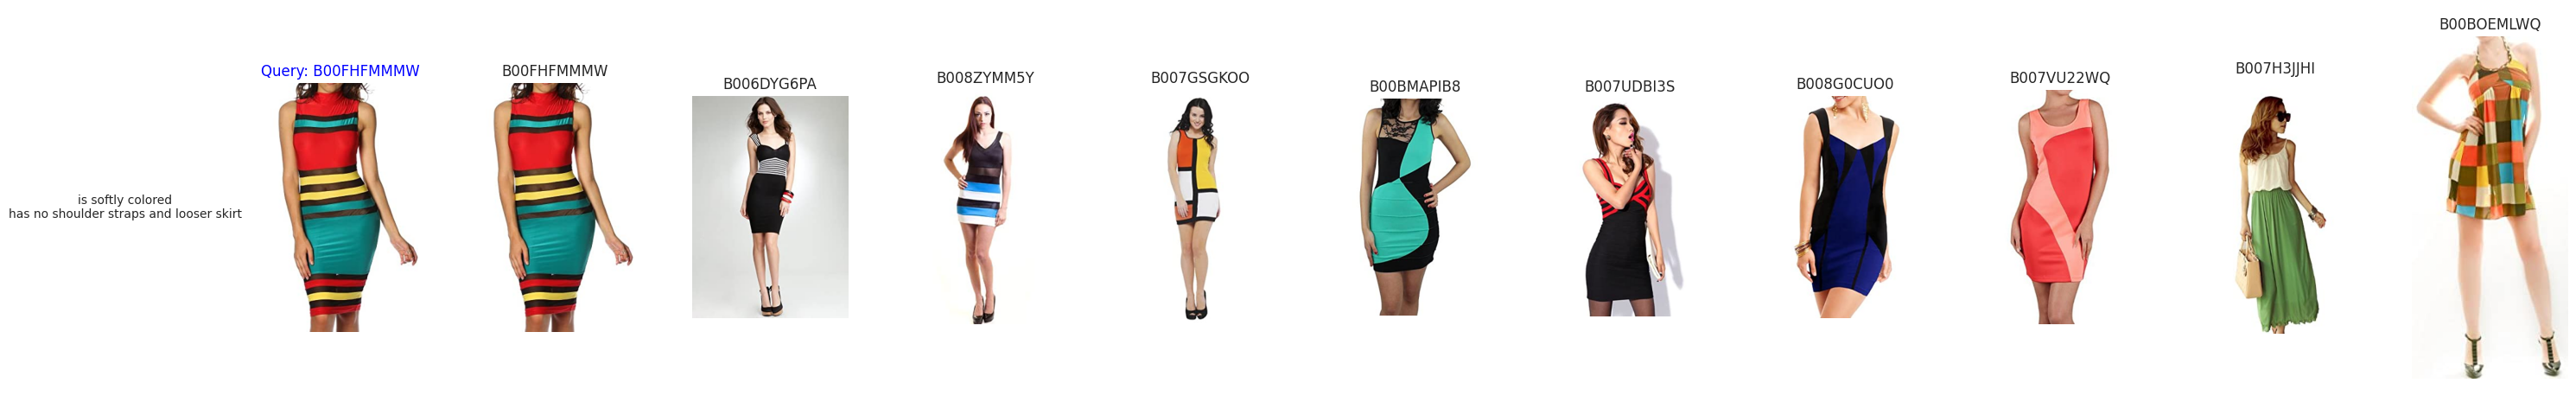

In [63]:
plot_retrieval_results_of_i(sorted_indices_dress, image_index_names_dress, target_names_dress, ground_truth_dress, top_k=10, i=11)

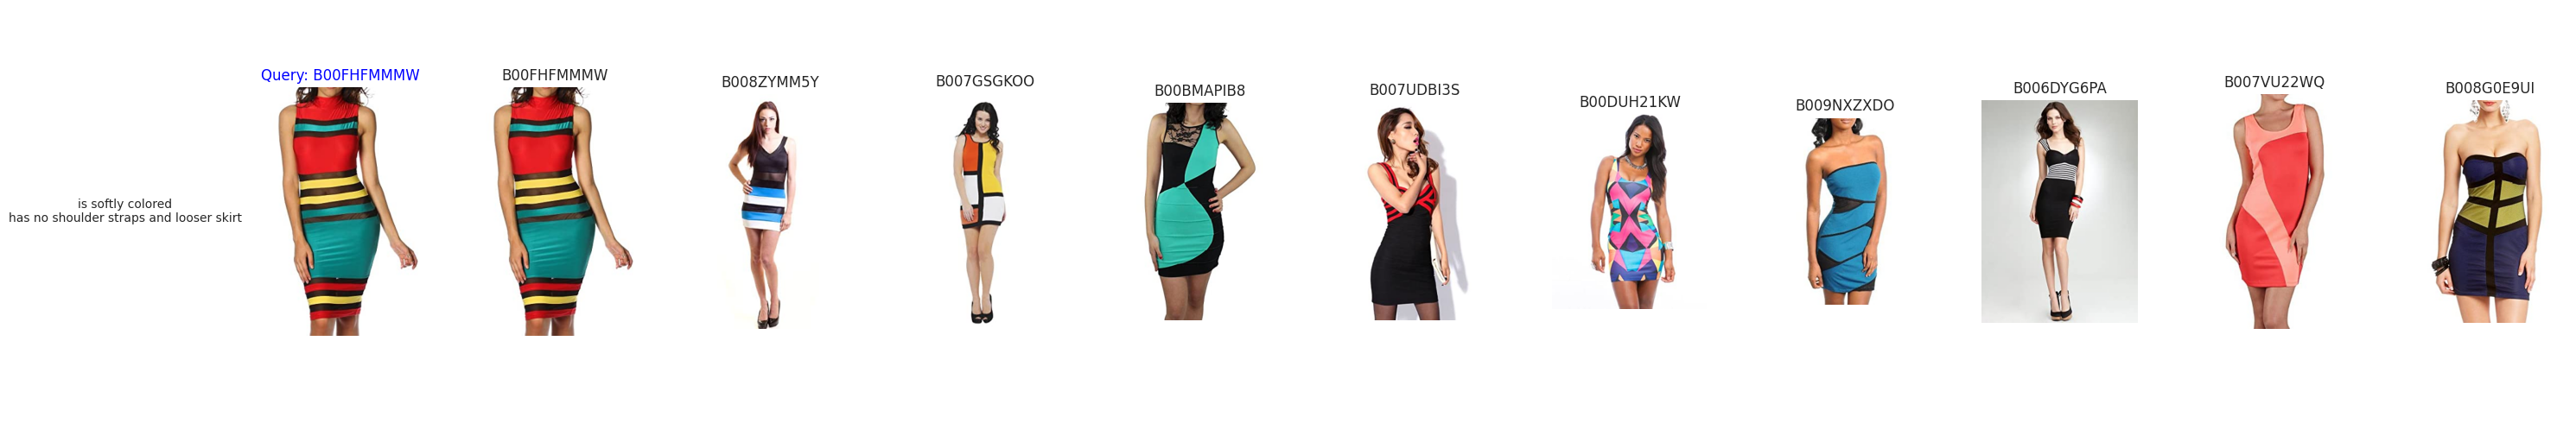

In [64]:
plot_retrieval_results_of_i(sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin, ground_truth_dress, top_k=10, i=11)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the results for the Shirt category</div>

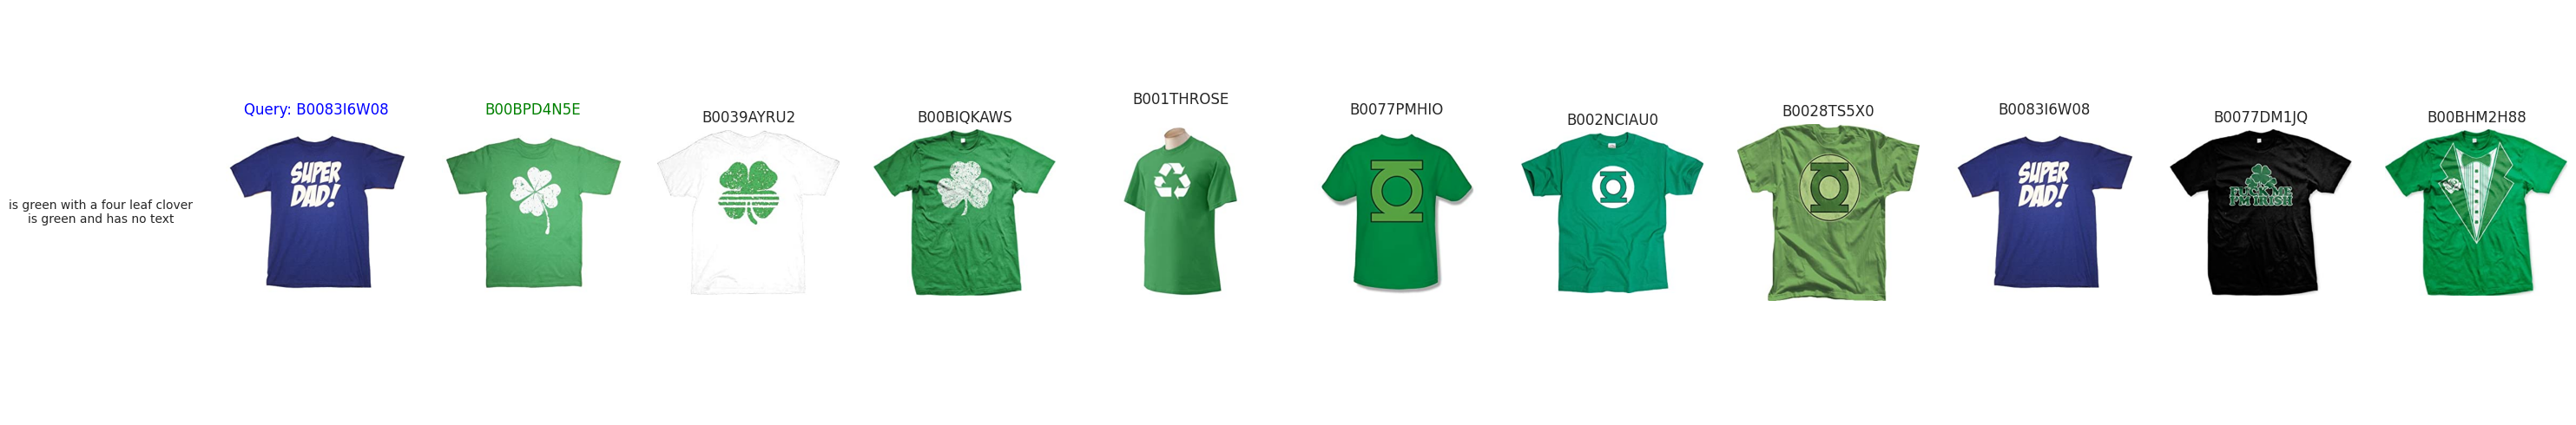

In [65]:
plot_retrieval_results_of_i(sorted_indices_shirt, image_index_names_shirt, target_names_shirt, ground_truth_shirt, top_k=10, i=1)

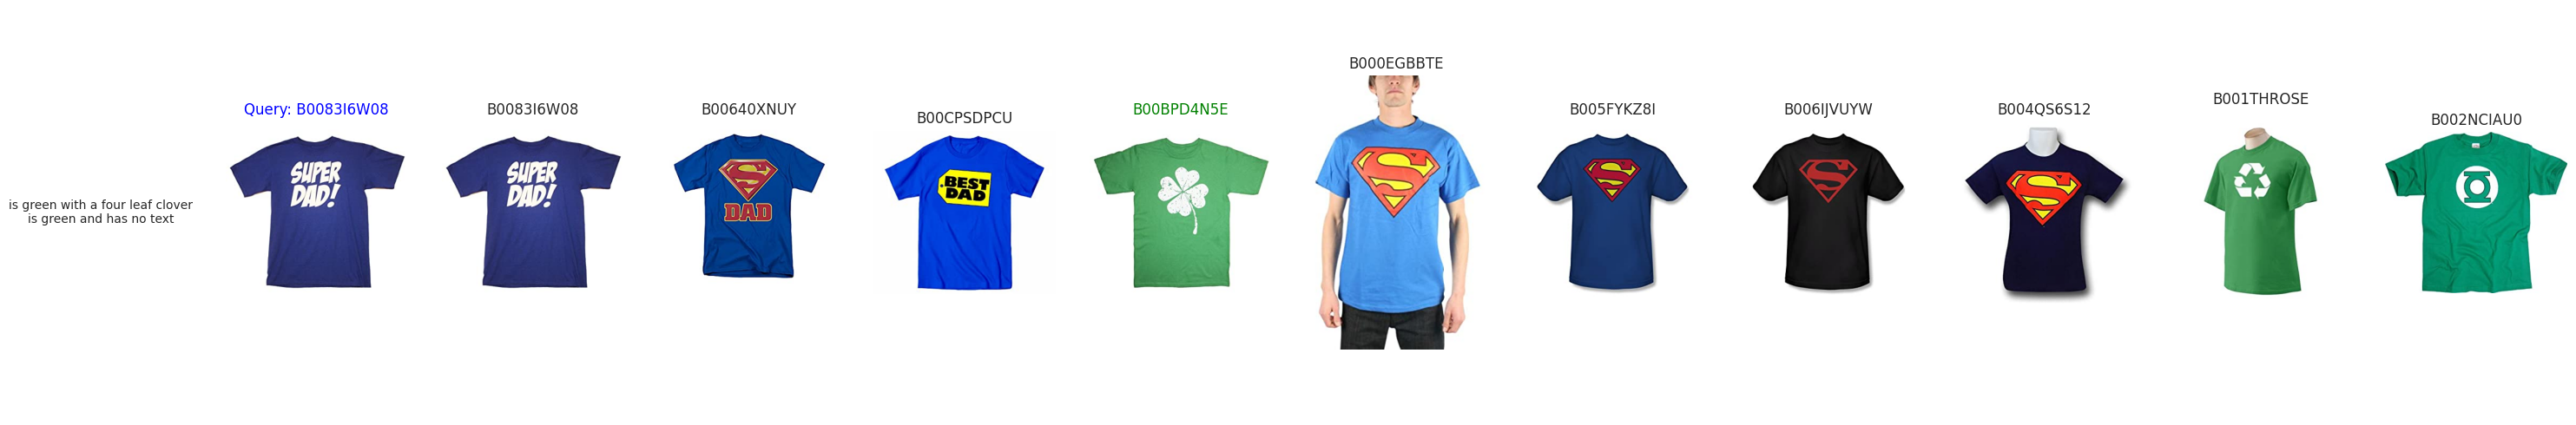

In [66]:
plot_retrieval_results_of_i(sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin, ground_truth_shirt, top_k=10, i=1)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the results for the TopTee category</div>

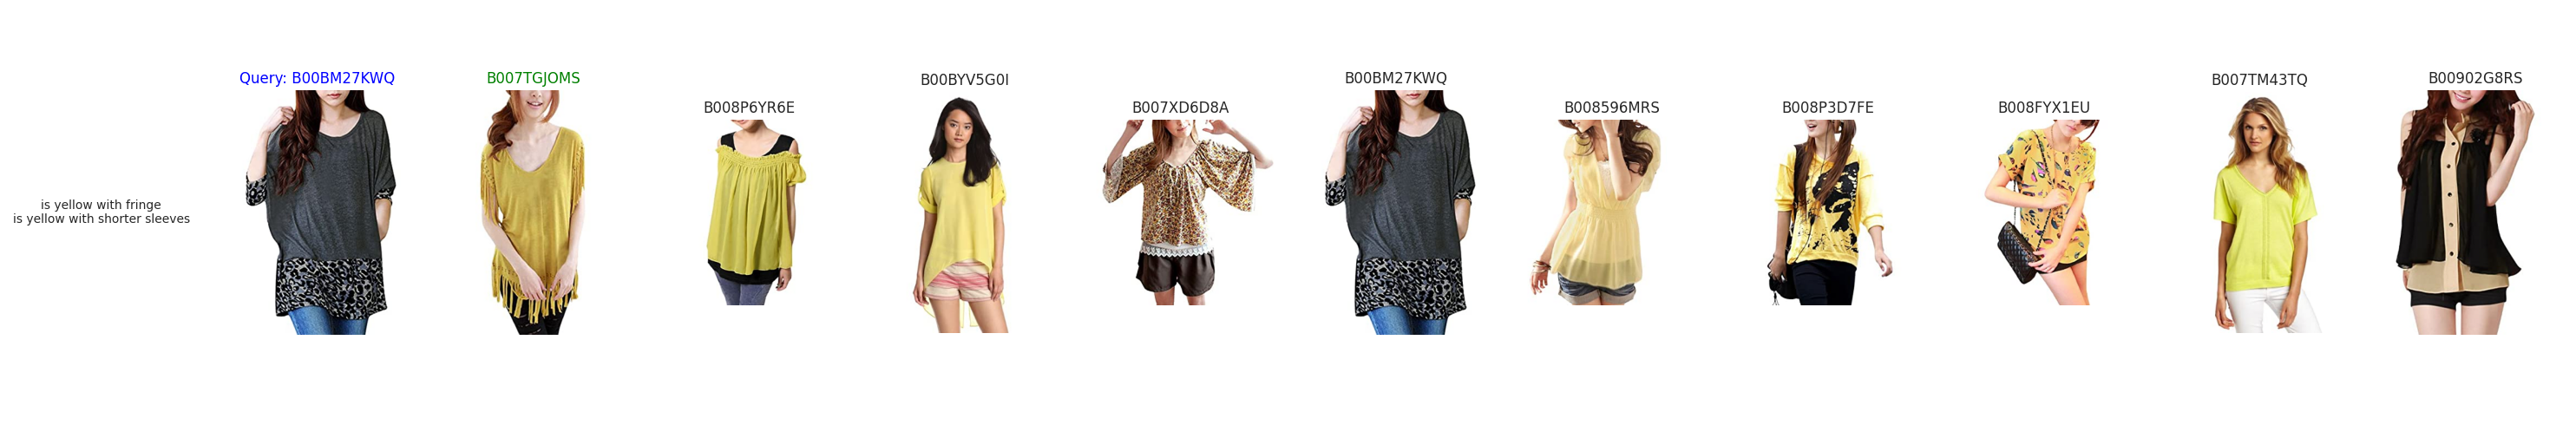

In [67]:
plot_retrieval_results_of_i(sorted_indices_toptee, image_index_names_toptee, target_names_toptee, ground_truth_toptee, top_k=10, i=2)

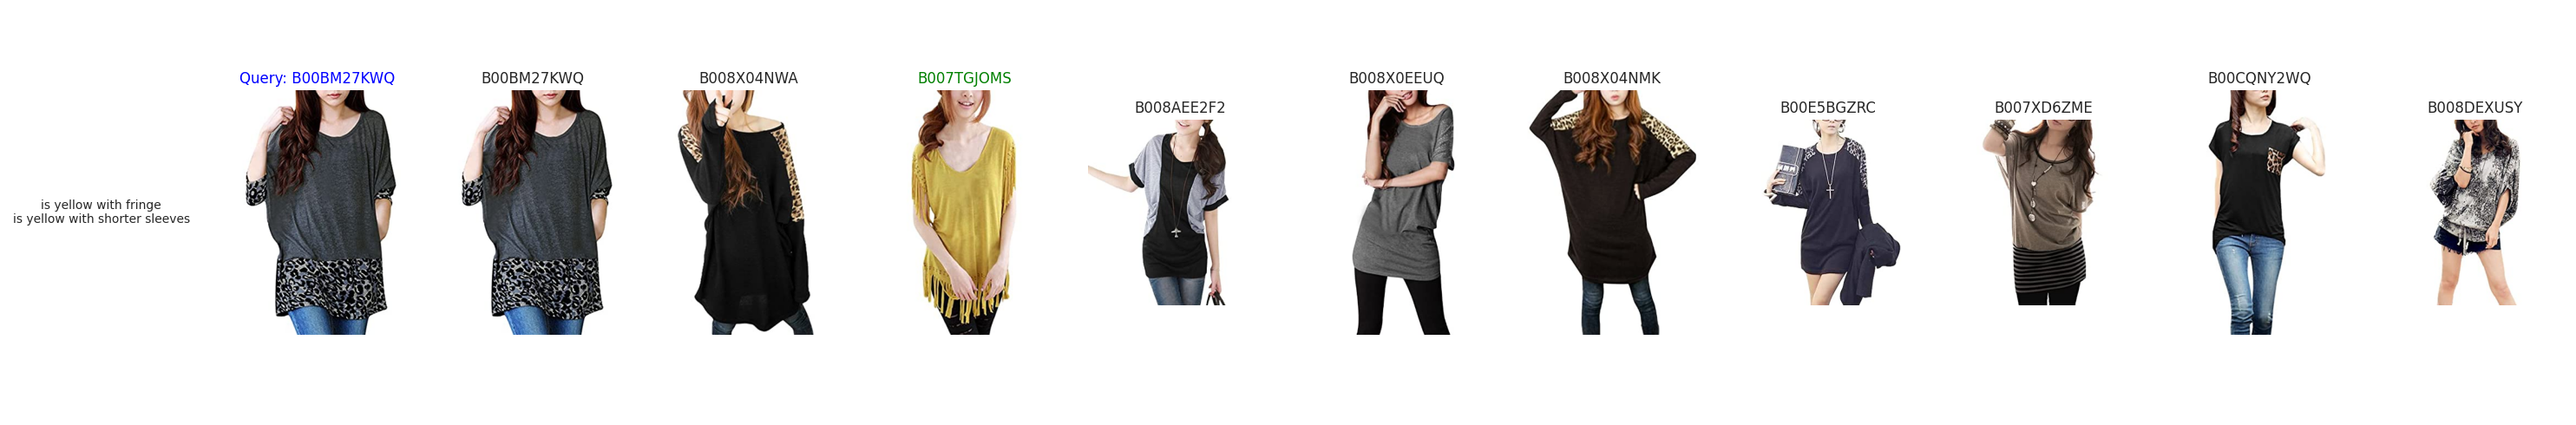

In [68]:
plot_retrieval_results_of_i(sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin, ground_truth_toptee, top_k=10, i=2)